# **AE1**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### **Available functions**

In [2]:
def simple_quadratic_function(x):
    return x[0]**2 + x[1]**2 + 2 * x[2]**2

def rastrigin(x):
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

### **Genetic Algorithm**

In [ ]:
class GeneticAlgorithm:
    def __init__(self, 
                 objective_function, 
                 dimension,
                 population_size=50, 
                 crossover_rate=0.9, 
                 mutation_rate=0.1, 
                 mutation_std=0.1, 
                 bounds=(-5.12, 5.12), 
                 elitism=True):
        """
        Initializes the genetic algorithm.

        Parameters:
            objective_function (callable): The function to minimize.
            dimension (int): Dimensionality of the search space.
            population_size (int): Number of individuals in the population.
            crossover_rate (float): Probability of applying crossover.
            mutation_rate (float): Probability of applying mutation to each gene.
            mutation_std (float): Standard deviation of the Gaussian mutation.
            bounds (tuple): Tuple of (lower_bound, upper_bound) for genes.
            elitism (bool): Whether to use elitism (carry best individual to next generation).
        """
        self.objective_function = objective_function
        self.dimension = dimension
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.mutation_std = mutation_std
        self.bounds = bounds
        self.elitism = elitism

        self.population = self.initialize_population()
        self.fitness = self.evaluate_population(self.population)
        
        self.best_fitness_history = []
        self.mean_fitness_history = []
        self.std_fitness_history = []


    def initialize_population(self):
        """
        Initializes the population with random real-valued individuals.

        Returns:
            numpy.ndarray: Initialized population.
        """
        lower, upper = self.bounds
        return np.random.uniform(lower, upper, (self.population_size, self.dimension))


    def evaluate_population(self, population):
        """
        Evaluates the fitness of the entire population.

        Parameters:
            population (numpy.ndarray): Population to evaluate.

        Returns:
            numpy.ndarray: Fitness values.
        """
        return np.apply_along_axis(self.objective_function, 1, population)


    def select_parents(self):
        """
        Selects two parents using tournament selection.

        Returns:
            tuple: Two selected parents.
        """
        tournament_size = 3
        selected = np.random.choice(self.population_size, tournament_size, replace=False)
        best_idx = selected[np.argmin(self.fitness[selected])]
        return self.population[best_idx]


    def crossover(self, parent1, parent2):
        """
        Performs one-point crossover.

        Parameters:
            parent1 (numpy.ndarray): First parent.
            parent2 (numpy.ndarray): Second parent.

        Returns:
            tuple: Two offspring.
        """
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.dimension)
            offspring1 = np.concatenate((parent1[:point], parent2[point:]))
            offspring2 = np.concatenate((parent2[:point], parent1[point:]))
            return offspring1, offspring2
        return parent1.copy(), parent2.copy()


    def mutate(self, individual):
        """
        Applies Gaussian mutation to an individual.

        Parameters:
            individual (numpy.ndarray): Individual to mutate.

        Returns:
            numpy.ndarray: Mutated individual.
        """
        for i in range(self.dimension):
            if np.random.rand() < self.mutation_rate:
                mutation = np.random.normal(0, self.mutation_std)
                individual[i] += mutation
                individual[i] = np.clip(individual[i], *self.bounds)
        return individual


    def evolve(self, generations=100, verbose=True):
        """
        Evolves the population over a number of generations.

        Parameters:
            generations (int): Number of generations.
            verbose (bool): Whether to print progress.

        Returns:
            tuple: Best individual and its fitness.
        """
        for generation in range(generations):
            new_population = []

            if self.elitism:
                elite_idx = np.argmin(self.fitness)
                elite = self.population[elite_idx].copy()
                new_population.append(elite)

            while len(new_population) < self.population_size:
                parent1 = self.select_parents()
                parent2 = self.select_parents()
                offspring1, offspring2 = self.crossover(parent1, parent2)
                new_population.extend([
                    self.mutate(offspring1), 
                    self.mutate(offspring2)
                ])

            self.population = np.array(new_population[:self.population_size])
            self.fitness = self.evaluate_population(self.population)
            
            best_fitness = np.min(self.fitness)
            mean_fitness = np.mean(self.fitness)
            std_fitness = np.std(self.fitness)

            self.best_fitness_history.append(best_fitness)
            self.mean_fitness_history.append(mean_fitness)
            self.std_fitness_history.append(std_fitness)

            if verbose and (generation + 1) % 10 == 0:
                print(f"Generation {generation + 1}: Best Fitness = {np.min(self.fitness):.6f}")

        best_idx = np.argmin(self.fitness)
        return self.population[best_idx], self.fitness[best_idx]
    
    
    def plot_fitness_progress(self, skip_first=10):
        """
        Plots the evolution of fitness over generations.

        This visualization includes:
        - Best fitness value per generation (blue line)
        - Mean fitness value per generation (orange line)
        - Shaded area representing one standard deviation above and below the mean

        Parameters:
            skip_first (int): Number of initial generations to skip in the plot.
                            Useful when early fitness values are too large and distort the scale.

        The method uses the recorded history of fitness values collected during evolution.
        """
        generations = range(skip_first + 1, len(self.best_fitness_history) + 1)
        best = self.best_fitness_history[skip_first:]
        mean = self.mean_fitness_history[skip_first:]
        std = self.std_fitness_history[skip_first:]

        plt.plot(generations, best, label='Best Fitness', color='blue')
        plt.plot(generations, mean, label='Mean Fitness', color='orange')
        
        lower = np.array(mean) - np.array(std)
        upper = np.array(mean) + np.array(std)
        plt.fill_between(generations, lower, upper, color='orange', alpha=0.3, label='Std Dev')

        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title(f'Fitness Progress Over Generations (without first {skip_first})')
        plt.legend()
        plt.grid(True)
        plt.show()

### **Tests**

In [4]:
crossover_rates = [0.1, 0.5, 0.9]
mutation_rates = [0.1, 0.5, 0.9]
mutation_stds = [0.1, 0.5, 1.0]
elitism_options = [True, False]

### **Simple quadratic function**


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 1.594729
Generation 20: Best Fitness = 0.686333
Generation 30: Best Fitness = 0.175289
Generation 40: Best Fitness = 0.002013
Generation 50: Best Fitness = 0.000159
Generation 60: Best Fitness = 0.000087
Generation 70: Best Fitness = 0.000027
Generation 80: Best Fitness = 0.000022
Generation 90: Best Fitness = 0.000016
Generation 100: Best Fitness = 0.000012
Best solution: [ 0.0002223  -0.00228375 -0.00177711]
Best value: 1.1581189502480183e-05


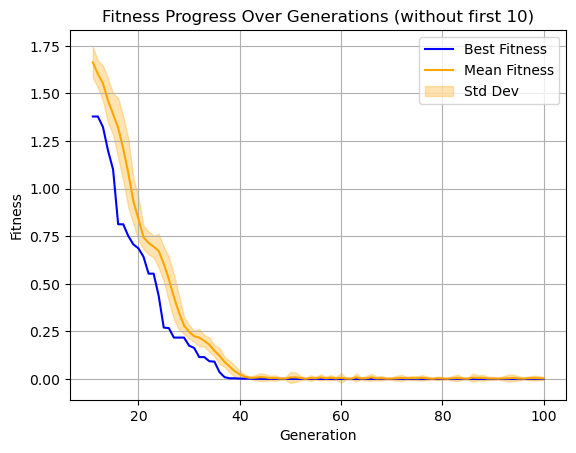


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 0.027922
Generation 20: Best Fitness = 0.000347
Generation 30: Best Fitness = 0.000071
Generation 40: Best Fitness = 0.000071
Generation 50: Best Fitness = 0.000013
Generation 60: Best Fitness = 0.000011
Generation 70: Best Fitness = 0.000011
Generation 80: Best Fitness = 0.000011
Generation 90: Best Fitness = 0.000004
Generation 100: Best Fitness = 0.000004
Best solution: [-0.00168671 -0.00119159 -0.00022105]
Best value: 4.362628032566199e-06


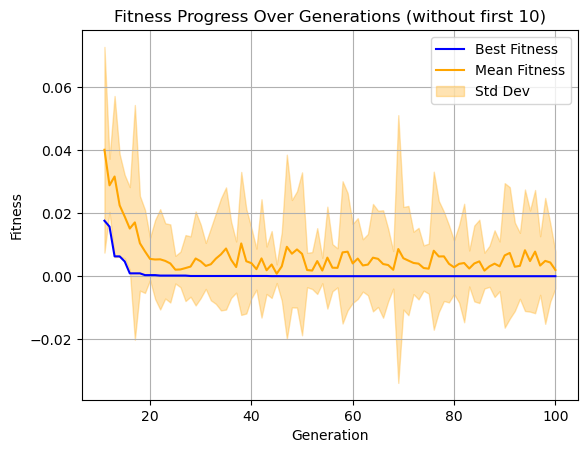


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 0.016714
Generation 20: Best Fitness = 0.001646
Generation 30: Best Fitness = 0.000384
Generation 40: Best Fitness = 0.000305
Generation 50: Best Fitness = 0.000305
Generation 60: Best Fitness = 0.000305
Generation 70: Best Fitness = 0.000301
Generation 80: Best Fitness = 0.000007
Generation 90: Best Fitness = 0.000007
Generation 100: Best Fitness = 0.000007
Best solution: [ 0.00114264 -0.0011854   0.00141843]
Best value: 6.734677901272467e-06


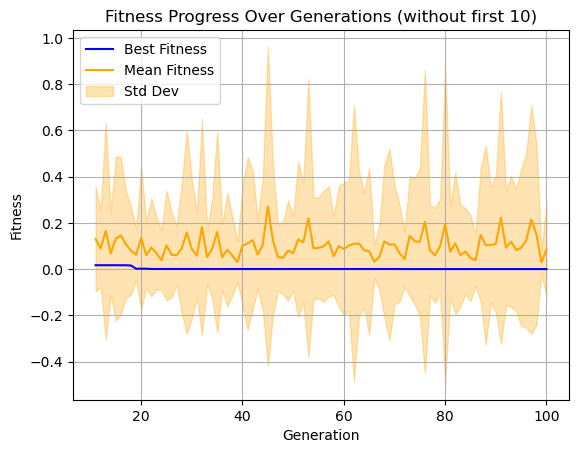


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 0.055217
Generation 20: Best Fitness = 0.009073
Generation 30: Best Fitness = 0.002545
Generation 40: Best Fitness = 0.001491
Generation 50: Best Fitness = 0.001118
Generation 60: Best Fitness = 0.000242
Generation 70: Best Fitness = 0.000242
Generation 80: Best Fitness = 0.000072
Generation 90: Best Fitness = 0.000072
Generation 100: Best Fitness = 0.000034
Best solution: [-0.00546272 -0.00198025  0.00020975]
Best value: 3.38506248192583e-05


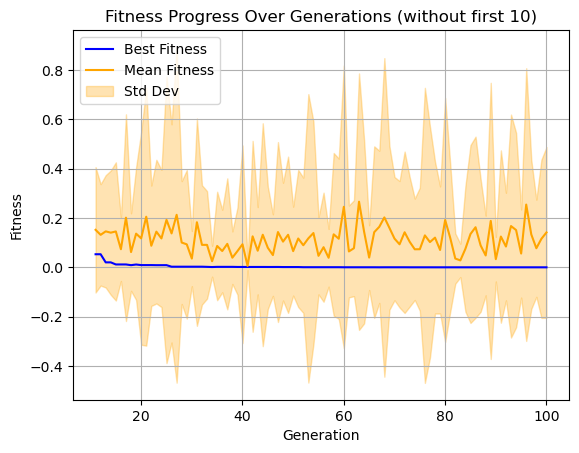


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 0.025151
Generation 20: Best Fitness = 0.001132
Generation 30: Best Fitness = 0.001132
Generation 40: Best Fitness = 0.000005
Generation 50: Best Fitness = 0.000005
Generation 60: Best Fitness = 0.000005
Generation 70: Best Fitness = 0.000005
Generation 80: Best Fitness = 0.000005
Generation 90: Best Fitness = 0.000005
Generation 100: Best Fitness = 0.000005
Best solution: [-0.00139938  0.00014398 -0.00114894]
Best value: 4.619115869589091e-06


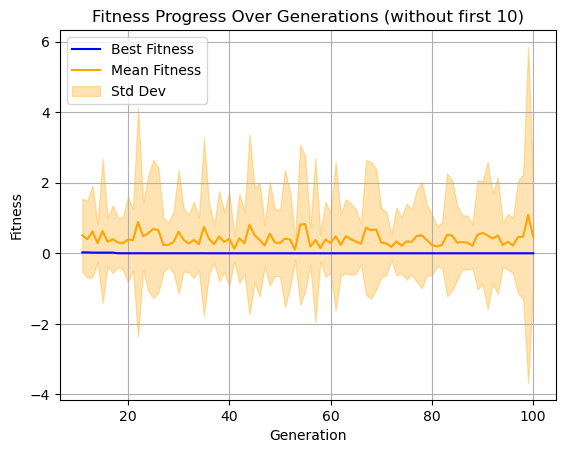


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 0.154890
Generation 20: Best Fitness = 0.008346
Generation 30: Best Fitness = 0.002718
Generation 40: Best Fitness = 0.000207
Generation 50: Best Fitness = 0.000207
Generation 60: Best Fitness = 0.000000
Generation 70: Best Fitness = 0.000000
Generation 80: Best Fitness = 0.000000
Generation 90: Best Fitness = 0.000000
Generation 100: Best Fitness = 0.000000
Best solution: [-4.47786926e-05 -1.90841961e-04  3.86956769e-04]
Best value: 3.3789686779776474e-07


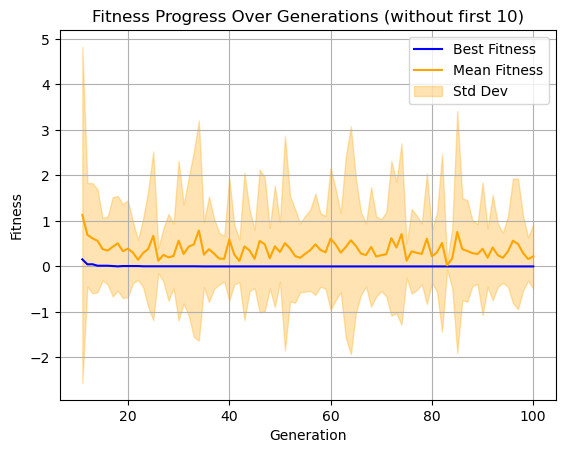


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 0.127172
Generation 20: Best Fitness = 0.000297
Generation 30: Best Fitness = 0.000081
Generation 40: Best Fitness = 0.000081
Generation 50: Best Fitness = 0.000069
Generation 60: Best Fitness = 0.000051
Generation 70: Best Fitness = 0.000051
Generation 80: Best Fitness = 0.000051
Generation 90: Best Fitness = 0.000051
Generation 100: Best Fitness = 0.000051
Best solution: [-0.00704645  0.00107357 -0.00051088]
Best value: 5.132699159363147e-05


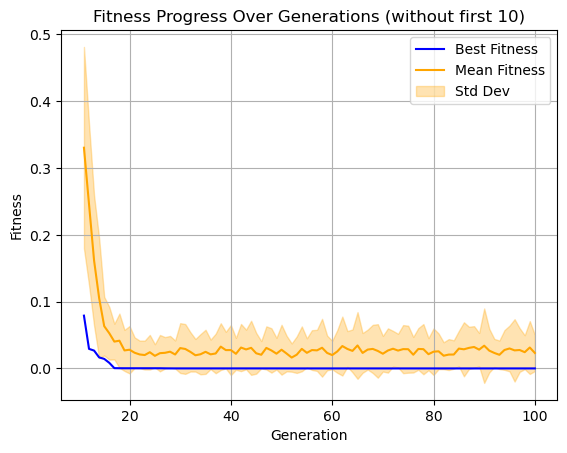


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 0.164324
Generation 20: Best Fitness = 0.000098
Generation 30: Best Fitness = 0.001200
Generation 40: Best Fitness = 0.001003
Generation 50: Best Fitness = 0.001416
Generation 60: Best Fitness = 0.001347
Generation 70: Best Fitness = 0.000529
Generation 80: Best Fitness = 0.000385
Generation 90: Best Fitness = 0.001022
Generation 100: Best Fitness = 0.001116
Best solution: [-0.01035101  0.03107322  0.00464472]
Best value: 0.0011158354042896143


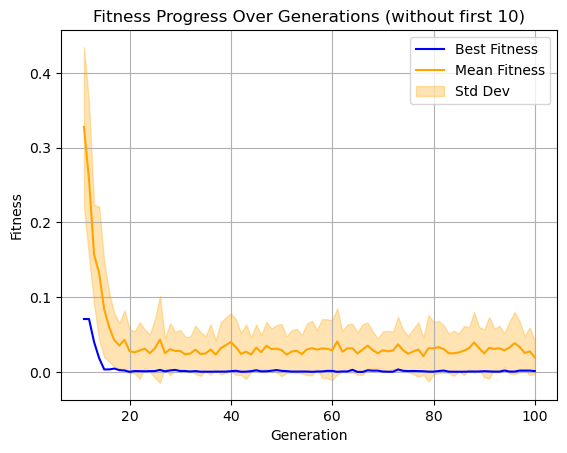


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 0.023626
Generation 20: Best Fitness = 0.004234
Generation 30: Best Fitness = 0.001633
Generation 40: Best Fitness = 0.001633
Generation 50: Best Fitness = 0.000742
Generation 60: Best Fitness = 0.000731
Generation 70: Best Fitness = 0.000731
Generation 80: Best Fitness = 0.000146
Generation 90: Best Fitness = 0.000119
Generation 100: Best Fitness = 0.000119
Best solution: [-0.00271128  0.01038343  0.00144352]
Best value: 0.00011933423393289413


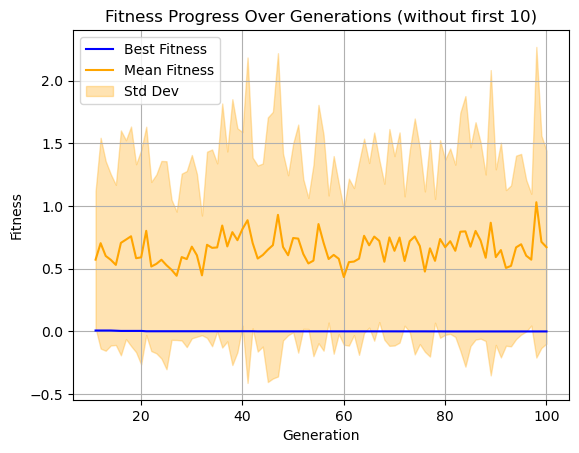


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 0.037340
Generation 20: Best Fitness = 0.108996
Generation 30: Best Fitness = 0.009360
Generation 40: Best Fitness = 0.057998
Generation 50: Best Fitness = 0.001183
Generation 60: Best Fitness = 0.013639
Generation 70: Best Fitness = 0.003237
Generation 80: Best Fitness = 0.024487
Generation 90: Best Fitness = 0.024678
Generation 100: Best Fitness = 0.005583
Best solution: [ 0.04540018 -0.0532404  -0.01853607]
Best value: 0.005582888119702015


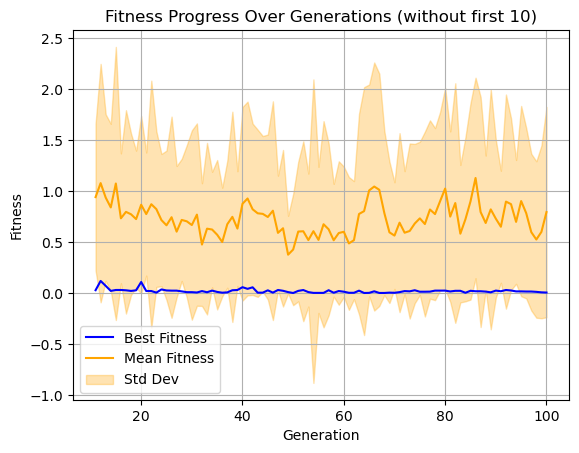


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 0.037889
Generation 20: Best Fitness = 0.019913
Generation 30: Best Fitness = 0.014735
Generation 40: Best Fitness = 0.013211
Generation 50: Best Fitness = 0.013211
Generation 60: Best Fitness = 0.001965
Generation 70: Best Fitness = 0.001931
Generation 80: Best Fitness = 0.001931
Generation 90: Best Fitness = 0.001931
Generation 100: Best Fitness = 0.001376
Best solution: [-0.02091502  0.00073675  0.02165724]
Best value: 0.0013760525901612061


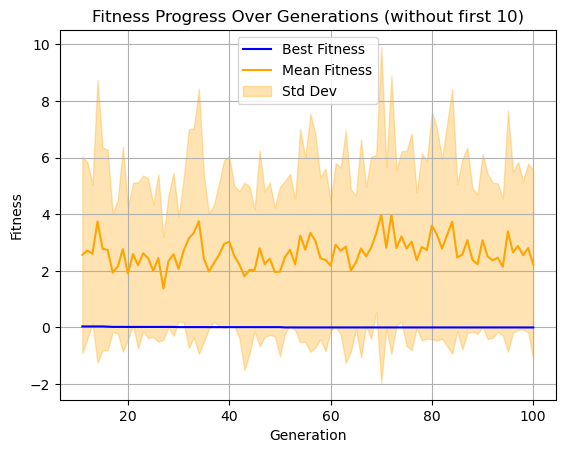


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 0.180653
Generation 20: Best Fitness = 0.045479
Generation 30: Best Fitness = 0.441480
Generation 40: Best Fitness = 0.016203
Generation 50: Best Fitness = 0.004239
Generation 60: Best Fitness = 0.156069
Generation 70: Best Fitness = 0.045839
Generation 80: Best Fitness = 0.275574
Generation 90: Best Fitness = 0.141943
Generation 100: Best Fitness = 0.000216
Best solution: [ 0.00039834 -0.01373817  0.00366351]
Best value: 0.000215738648997519


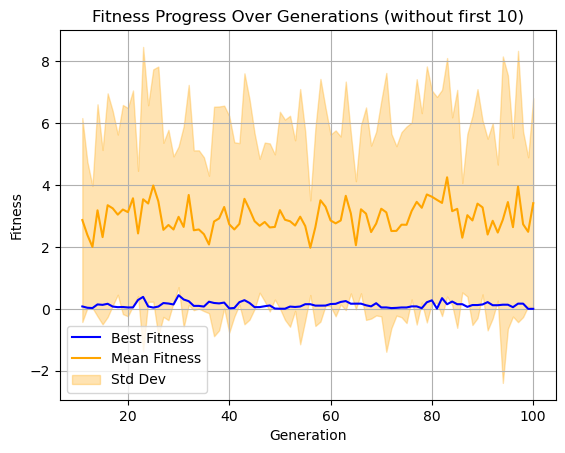


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 0.004093
Generation 20: Best Fitness = 0.000117
Generation 30: Best Fitness = 0.000117
Generation 40: Best Fitness = 0.000117
Generation 50: Best Fitness = 0.000117
Generation 60: Best Fitness = 0.000117
Generation 70: Best Fitness = 0.000117
Generation 80: Best Fitness = 0.000117
Generation 90: Best Fitness = 0.000117
Generation 100: Best Fitness = 0.000117
Best solution: [-0.00299381  0.00348529  0.00693624]
Best value: 0.00011733301814253525


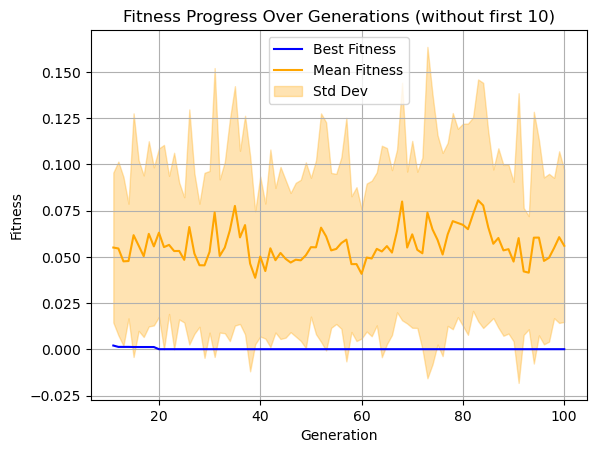


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 0.001487
Generation 20: Best Fitness = 0.009985
Generation 30: Best Fitness = 0.011197
Generation 40: Best Fitness = 0.006670
Generation 50: Best Fitness = 0.007191
Generation 60: Best Fitness = 0.004132
Generation 70: Best Fitness = 0.000540
Generation 80: Best Fitness = 0.002014
Generation 90: Best Fitness = 0.002290
Generation 100: Best Fitness = 0.001514
Best solution: [-0.00535364  0.02810528  0.01865342]
Best value: 0.00151446878832804


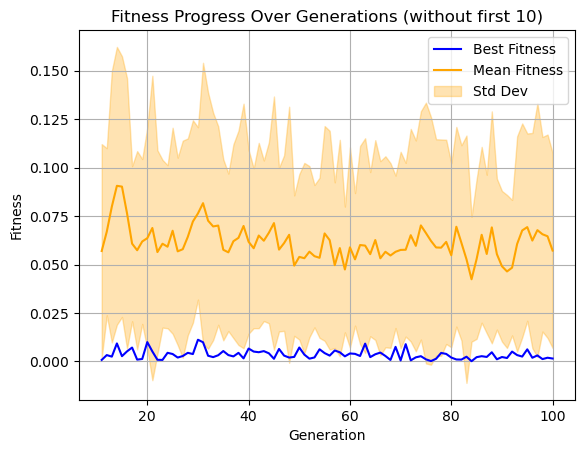


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 0.031001
Generation 20: Best Fitness = 0.029095
Generation 30: Best Fitness = 0.016790
Generation 40: Best Fitness = 0.016790
Generation 50: Best Fitness = 0.016790
Generation 60: Best Fitness = 0.006919
Generation 70: Best Fitness = 0.006919
Generation 80: Best Fitness = 0.006919
Generation 90: Best Fitness = 0.006919
Generation 100: Best Fitness = 0.003715
Best solution: [ 0.05147426 -0.02242163 -0.01677785]
Best value: 0.003715321791333421


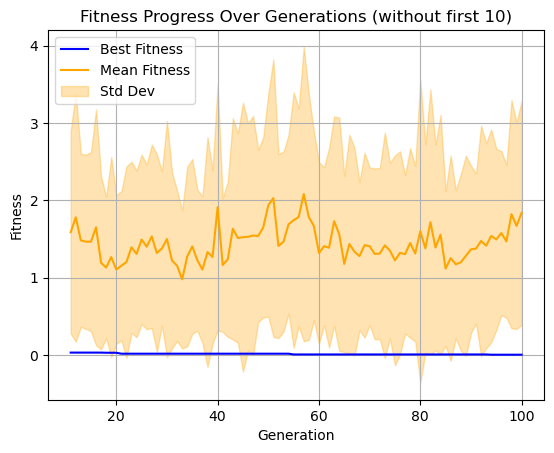


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 0.121742
Generation 20: Best Fitness = 0.197700
Generation 30: Best Fitness = 0.032295
Generation 40: Best Fitness = 0.053869
Generation 50: Best Fitness = 0.067554
Generation 60: Best Fitness = 0.036971
Generation 70: Best Fitness = 0.062625
Generation 80: Best Fitness = 0.085340
Generation 90: Best Fitness = 0.010165
Generation 100: Best Fitness = 0.081731
Best solution: [-0.04753259 -0.11913386 -0.18066397]
Best value: 0.08173116385461751


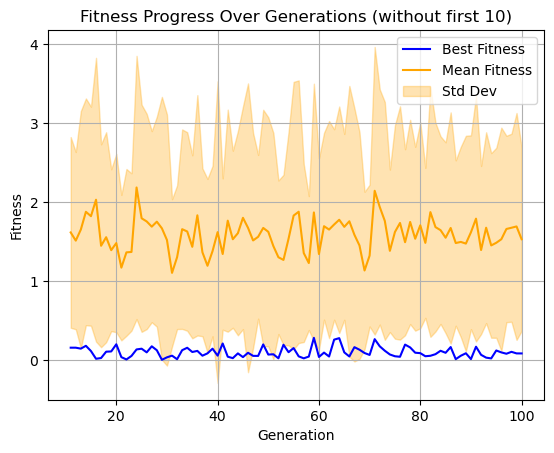


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 0.152383
Generation 20: Best Fitness = 0.111434
Generation 30: Best Fitness = 0.046595
Generation 40: Best Fitness = 0.046595
Generation 50: Best Fitness = 0.046595
Generation 60: Best Fitness = 0.042488
Generation 70: Best Fitness = 0.042488
Generation 80: Best Fitness = 0.020205
Generation 90: Best Fitness = 0.020205
Generation 100: Best Fitness = 0.020205
Best solution: [0.05469137 0.10233444 0.05805785]
Best value: 0.020204912764785067


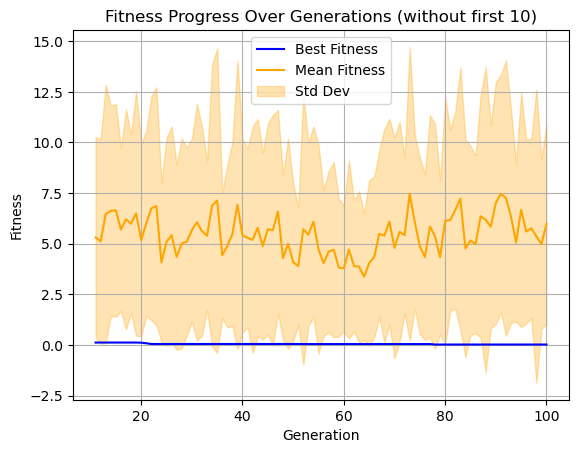


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 0.825229
Generation 20: Best Fitness = 0.459723
Generation 30: Best Fitness = 0.095513
Generation 40: Best Fitness = 0.150771
Generation 50: Best Fitness = 0.101050
Generation 60: Best Fitness = 0.076426
Generation 70: Best Fitness = 0.803261
Generation 80: Best Fitness = 0.004935
Generation 90: Best Fitness = 0.387757
Generation 100: Best Fitness = 0.222354
Best solution: [0.45933217 0.07667974 0.05238235]
Best value: 0.22235364339761862


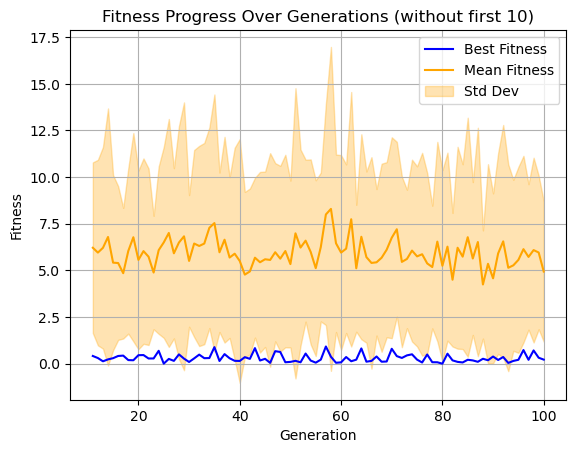


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 0.000062
Generation 20: Best Fitness = 0.000004
Generation 30: Best Fitness = 0.000004
Generation 40: Best Fitness = 0.000004
Generation 50: Best Fitness = 0.000004
Generation 60: Best Fitness = 0.000004
Generation 70: Best Fitness = 0.000004
Generation 80: Best Fitness = 0.000003
Generation 90: Best Fitness = 0.000003
Generation 100: Best Fitness = 0.000003
Best solution: [0.00014695 0.00147447 0.00040748]
Best value: 2.5277527228039054e-06


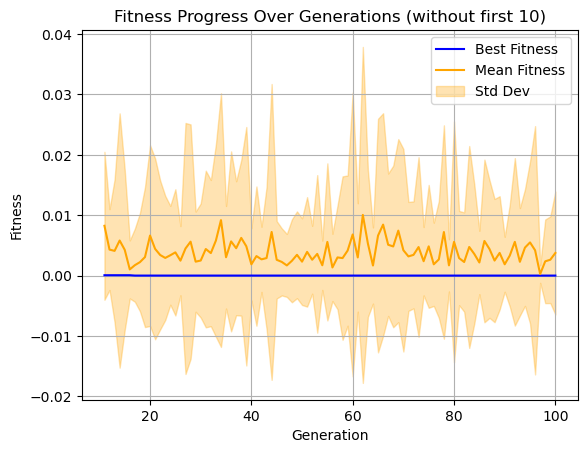


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 0.058707
Generation 20: Best Fitness = 0.000150
Generation 30: Best Fitness = 0.000013
Generation 40: Best Fitness = 0.000013
Generation 50: Best Fitness = 0.000010
Generation 60: Best Fitness = 0.000006
Generation 70: Best Fitness = 0.000006
Generation 80: Best Fitness = 0.000006
Generation 90: Best Fitness = 0.000006
Generation 100: Best Fitness = 0.000002
Best solution: [0.00129225 0.00025132 0.000227  ]
Best value: 1.836138538378009e-06


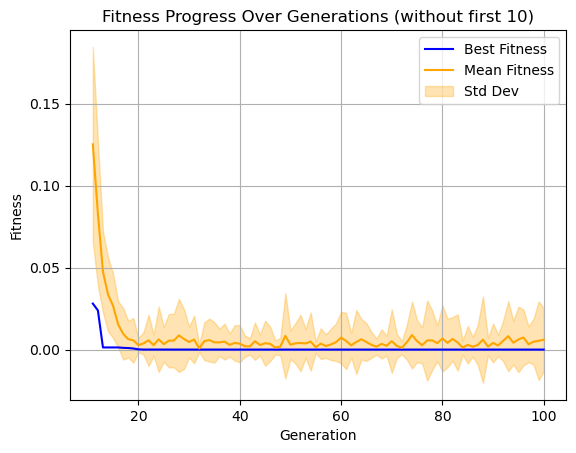


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 0.026021
Generation 20: Best Fitness = 0.000064
Generation 30: Best Fitness = 0.000064
Generation 40: Best Fitness = 0.000064
Generation 50: Best Fitness = 0.000064
Generation 60: Best Fitness = 0.000064
Generation 70: Best Fitness = 0.000064
Generation 80: Best Fitness = 0.000064
Generation 90: Best Fitness = 0.000061
Generation 100: Best Fitness = 0.000050
Best solution: [-0.00057425 -0.00551161  0.00310318]
Best value: 4.996709179901712e-05


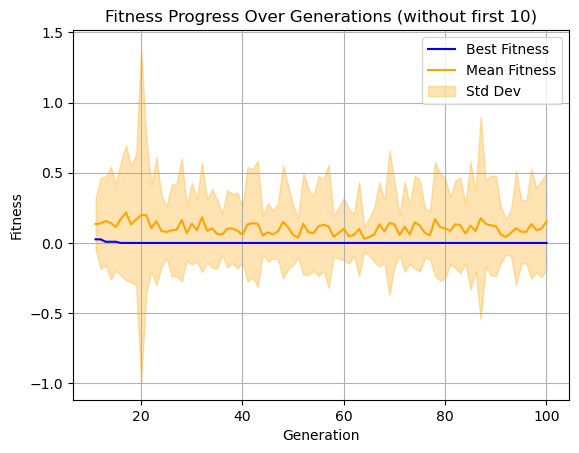


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 0.006552
Generation 20: Best Fitness = 0.003251
Generation 30: Best Fitness = 0.002600
Generation 40: Best Fitness = 0.000035
Generation 50: Best Fitness = 0.000003
Generation 60: Best Fitness = 0.000003
Generation 70: Best Fitness = 0.000003
Generation 80: Best Fitness = 0.000003
Generation 90: Best Fitness = 0.000003
Generation 100: Best Fitness = 0.000003
Best solution: [-0.00030914 -0.00058948 -0.00108885]
Best value: 2.8142153244957783e-06


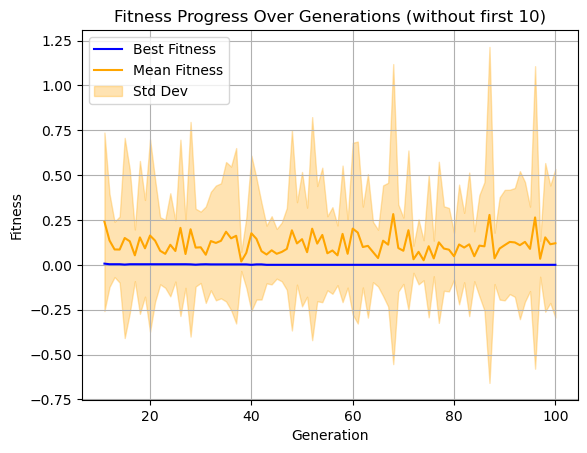


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 0.030519
Generation 20: Best Fitness = 0.000304
Generation 30: Best Fitness = 0.000303
Generation 40: Best Fitness = 0.000303
Generation 50: Best Fitness = 0.000303
Generation 60: Best Fitness = 0.000303
Generation 70: Best Fitness = 0.000303
Generation 80: Best Fitness = 0.000303
Generation 90: Best Fitness = 0.000303
Generation 100: Best Fitness = 0.000303
Best solution: [-0.00105265  0.01724413 -0.00145248]
Best value: 0.00030268744801066237


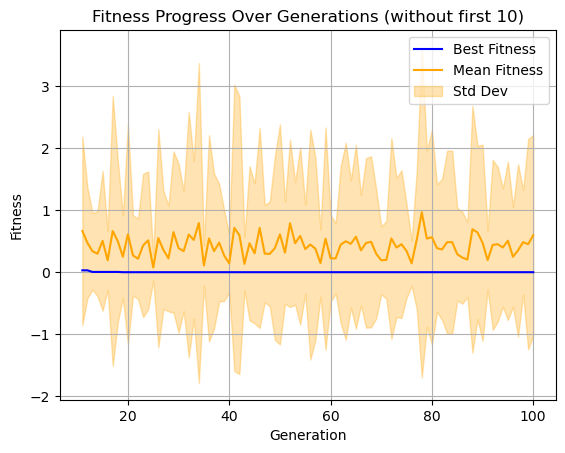


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 0.051492
Generation 20: Best Fitness = 0.006301
Generation 30: Best Fitness = 0.000420
Generation 40: Best Fitness = 0.000147
Generation 50: Best Fitness = 0.000147
Generation 60: Best Fitness = 0.000147
Generation 70: Best Fitness = 0.000147
Generation 80: Best Fitness = 0.000147
Generation 90: Best Fitness = 0.000147
Generation 100: Best Fitness = 0.000103
Best solution: [ 0.00162097  0.00065575 -0.00705483]
Best value: 0.00010259892857021392


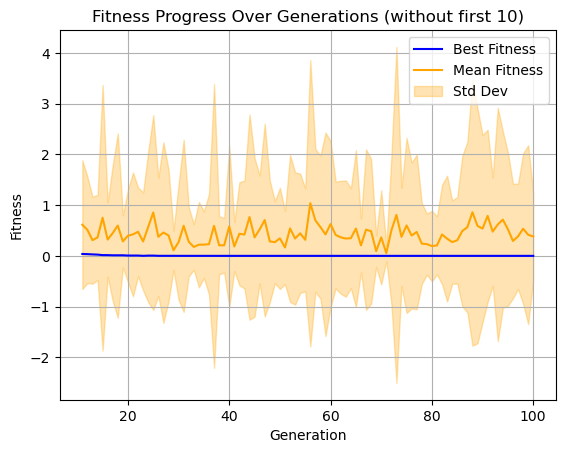


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 0.263285
Generation 20: Best Fitness = 0.002821
Generation 30: Best Fitness = 0.000253
Generation 40: Best Fitness = 0.000089
Generation 50: Best Fitness = 0.000089
Generation 60: Best Fitness = 0.000082
Generation 70: Best Fitness = 0.000082
Generation 80: Best Fitness = 0.000069
Generation 90: Best Fitness = 0.000069
Generation 100: Best Fitness = 0.000069
Best solution: [-0.00062906  0.00546786 -0.00440803]
Best value: 6.915456353646479e-05


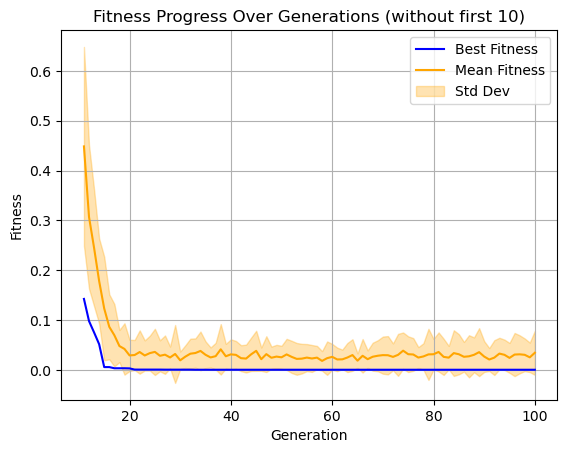


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 0.029965
Generation 20: Best Fitness = 0.001428
Generation 30: Best Fitness = 0.000836
Generation 40: Best Fitness = 0.000241
Generation 50: Best Fitness = 0.000195
Generation 60: Best Fitness = 0.001323
Generation 70: Best Fitness = 0.001658
Generation 80: Best Fitness = 0.000253
Generation 90: Best Fitness = 0.000305
Generation 100: Best Fitness = 0.000851
Best solution: [ 0.01223577 -0.00109278 -0.01871055]
Best value: 0.0008510774772047583


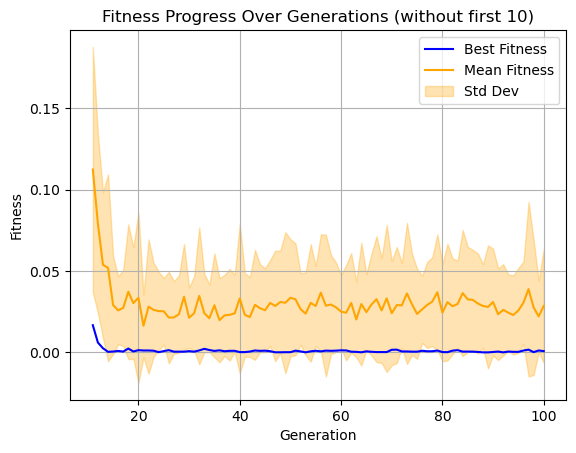


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 0.004987
Generation 20: Best Fitness = 0.003112
Generation 30: Best Fitness = 0.001727
Generation 40: Best Fitness = 0.001727
Generation 50: Best Fitness = 0.001727
Generation 60: Best Fitness = 0.001727
Generation 70: Best Fitness = 0.000593
Generation 80: Best Fitness = 0.000593
Generation 90: Best Fitness = 0.000593
Generation 100: Best Fitness = 0.000593
Best solution: [0.00421894 0.02344612 0.00359986]
Best value: 0.0005934378130235902


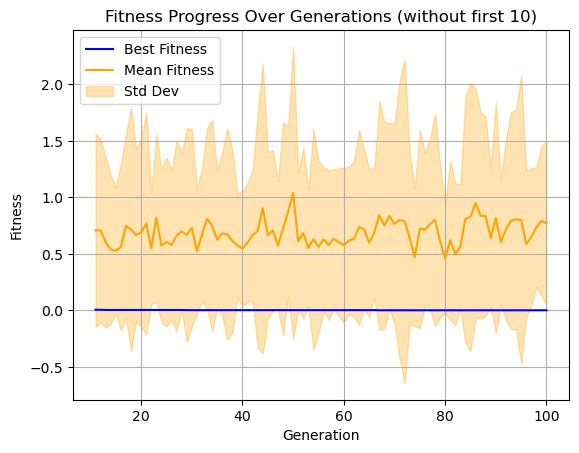


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 0.155140
Generation 20: Best Fitness = 0.002604
Generation 30: Best Fitness = 0.053871
Generation 40: Best Fitness = 0.018891
Generation 50: Best Fitness = 0.011119
Generation 60: Best Fitness = 0.026732
Generation 70: Best Fitness = 0.057098
Generation 80: Best Fitness = 0.016598
Generation 90: Best Fitness = 0.044978
Generation 100: Best Fitness = 0.038398
Best solution: [-0.01479569  0.00640464  0.13809043]
Best value: 0.038397866500158244


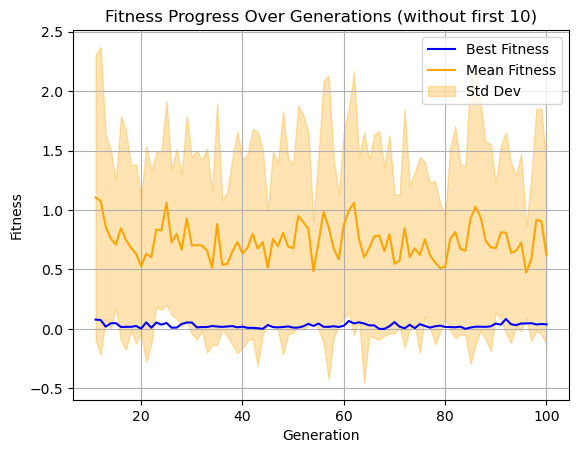


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 0.036181
Generation 20: Best Fitness = 0.014968
Generation 30: Best Fitness = 0.009649
Generation 40: Best Fitness = 0.005796
Generation 50: Best Fitness = 0.005796
Generation 60: Best Fitness = 0.005796
Generation 70: Best Fitness = 0.003861
Generation 80: Best Fitness = 0.003861
Generation 90: Best Fitness = 0.000921
Generation 100: Best Fitness = 0.000921
Best solution: [0.02726981 0.01176447 0.00441767]
Best value: 0.0009210767636670743


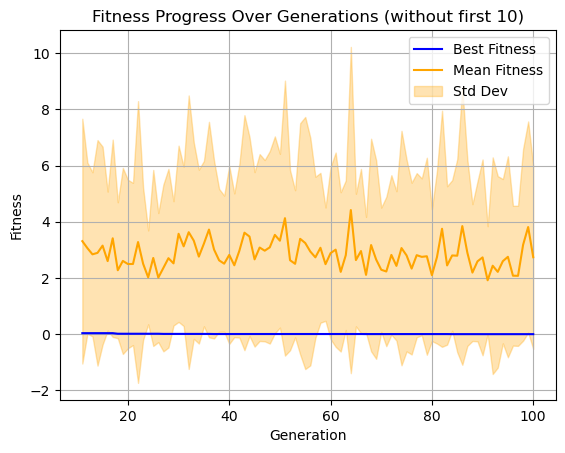


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 0.007223
Generation 20: Best Fitness = 0.159676
Generation 30: Best Fitness = 0.072164
Generation 40: Best Fitness = 0.133765
Generation 50: Best Fitness = 0.077278
Generation 60: Best Fitness = 0.102899
Generation 70: Best Fitness = 0.098782
Generation 80: Best Fitness = 0.022184
Generation 90: Best Fitness = 0.094458
Generation 100: Best Fitness = 0.061348
Best solution: [-0.03247475  0.15646194 -0.13381556]
Best value: 0.06134815635013756


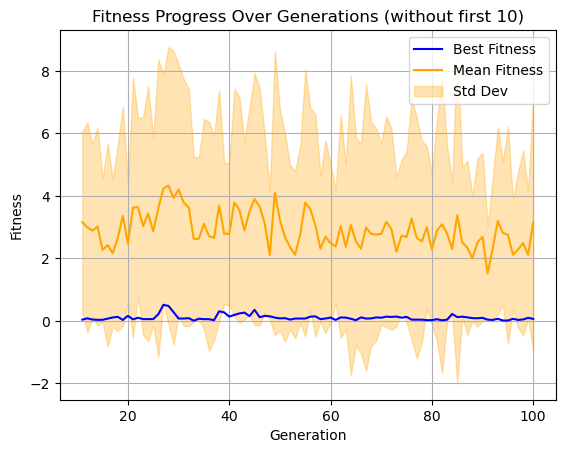


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 0.001246
Generation 20: Best Fitness = 0.000362
Generation 30: Best Fitness = 0.000362
Generation 40: Best Fitness = 0.000362
Generation 50: Best Fitness = 0.000145
Generation 60: Best Fitness = 0.000117
Generation 70: Best Fitness = 0.000117
Generation 80: Best Fitness = 0.000117
Generation 90: Best Fitness = 0.000117
Generation 100: Best Fitness = 0.000117
Best solution: [ 0.00781928 -0.00302105 -0.00481453]
Best value: 0.00011662739008714553


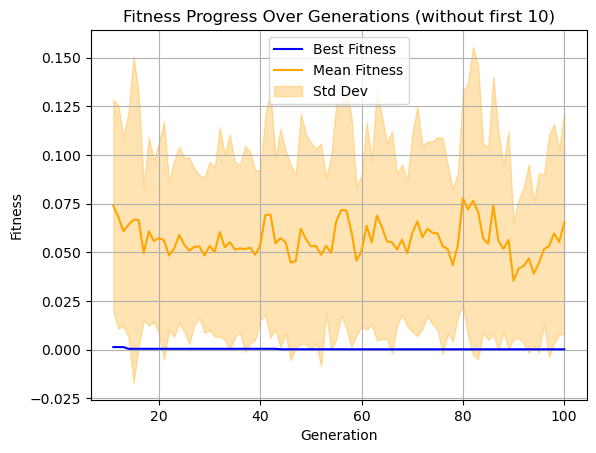


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 0.081138
Generation 20: Best Fitness = 0.000105
Generation 30: Best Fitness = 0.005428
Generation 40: Best Fitness = 0.011009
Generation 50: Best Fitness = 0.001835
Generation 60: Best Fitness = 0.002868
Generation 70: Best Fitness = 0.000306
Generation 80: Best Fitness = 0.002105
Generation 90: Best Fitness = 0.004306
Generation 100: Best Fitness = 0.000869
Best solution: [ 0.01183778 -0.02626971 -0.00437853]
Best value: 0.0008685737233424605


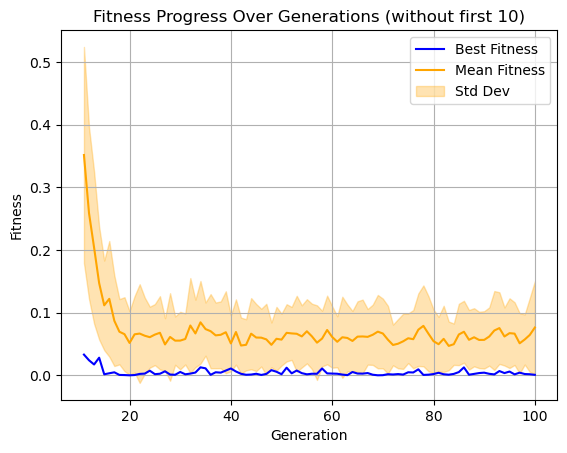


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 0.012041
Generation 20: Best Fitness = 0.012041
Generation 30: Best Fitness = 0.012041
Generation 40: Best Fitness = 0.012041
Generation 50: Best Fitness = 0.012041
Generation 60: Best Fitness = 0.012041
Generation 70: Best Fitness = 0.012041
Generation 80: Best Fitness = 0.010904
Generation 90: Best Fitness = 0.009492
Generation 100: Best Fitness = 0.001354
Best solution: [-0.03577942 -0.00511563 -0.00488231]
Best value: 0.001354010426565782


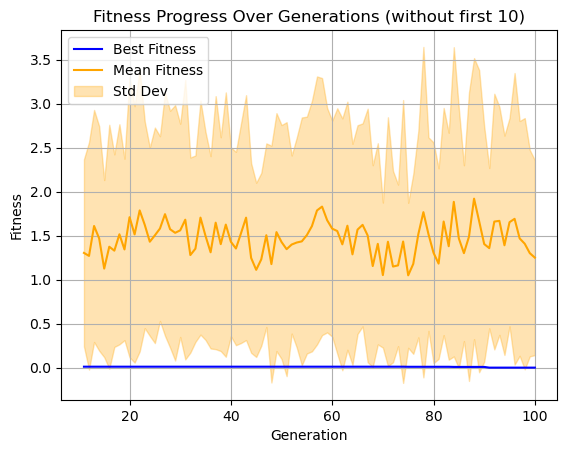


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 0.288874
Generation 20: Best Fitness = 0.190671
Generation 30: Best Fitness = 0.090142
Generation 40: Best Fitness = 0.077490
Generation 50: Best Fitness = 0.057605
Generation 60: Best Fitness = 0.027191
Generation 70: Best Fitness = 0.007415
Generation 80: Best Fitness = 0.030011
Generation 90: Best Fitness = 0.042038
Generation 100: Best Fitness = 0.107131
Best solution: [ 0.17046574 -0.13157663 -0.17429817]
Best value: 0.10713068297252377


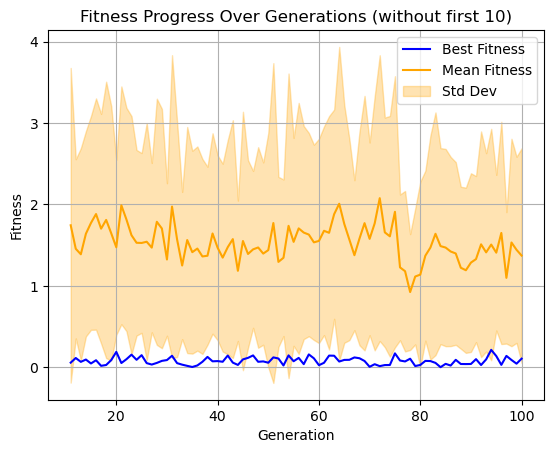


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 0.112274
Generation 20: Best Fitness = 0.012377
Generation 30: Best Fitness = 0.012377
Generation 40: Best Fitness = 0.012377
Generation 50: Best Fitness = 0.012377
Generation 60: Best Fitness = 0.012377
Generation 70: Best Fitness = 0.010750
Generation 80: Best Fitness = 0.010750
Generation 90: Best Fitness = 0.010750
Generation 100: Best Fitness = 0.010750
Best solution: [0.07315264 0.06185396 0.02804476]
Best value: 0.010750237334018121


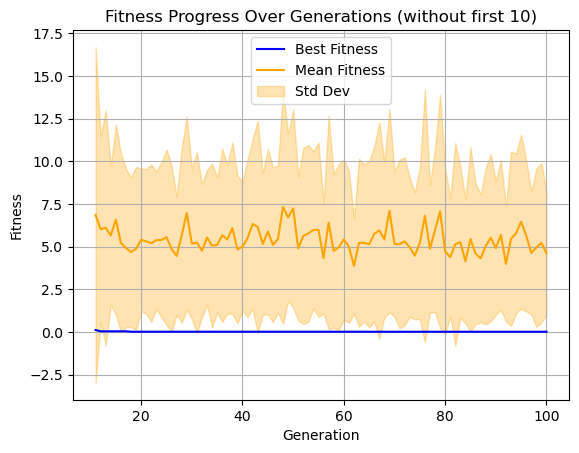


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 0.415749
Generation 20: Best Fitness = 0.259423
Generation 30: Best Fitness = 0.381263
Generation 40: Best Fitness = 0.246700
Generation 50: Best Fitness = 0.132668
Generation 60: Best Fitness = 0.096698
Generation 70: Best Fitness = 0.263561
Generation 80: Best Fitness = 0.106177
Generation 90: Best Fitness = 0.127949
Generation 100: Best Fitness = 0.030393
Best solution: [0.00939917 0.06794395 0.11333183]
Best value: 0.030392930206861284


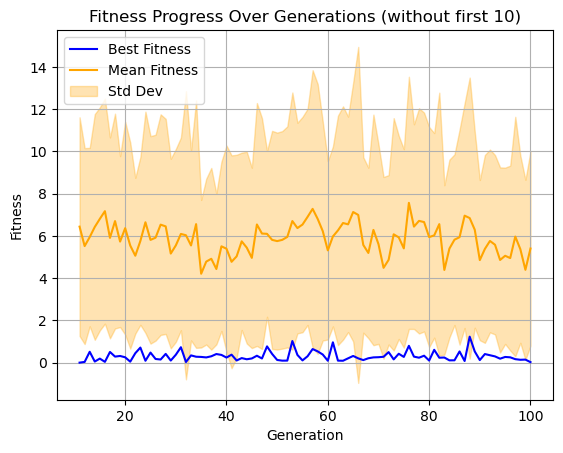


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 0.032601
Generation 20: Best Fitness = 0.000560
Generation 30: Best Fitness = 0.000102
Generation 40: Best Fitness = 0.000024
Generation 50: Best Fitness = 0.000014
Generation 60: Best Fitness = 0.000003
Generation 70: Best Fitness = 0.000001
Generation 80: Best Fitness = 0.000001
Generation 90: Best Fitness = 0.000001
Generation 100: Best Fitness = 0.000000
Best solution: [-0.00017836 -0.00020116 -0.00018822]
Best value: 1.431289804691764e-07


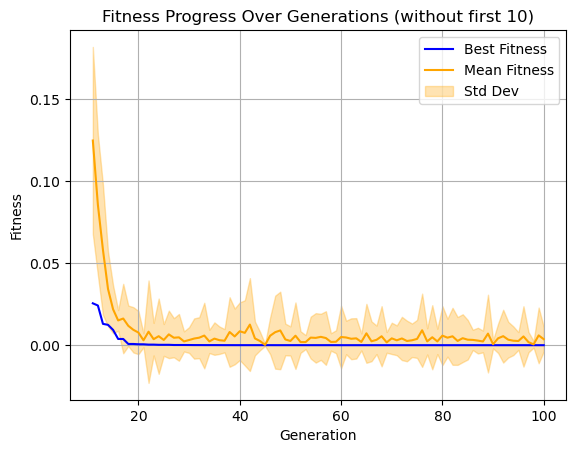


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 0.020850
Generation 20: Best Fitness = 0.000126
Generation 30: Best Fitness = 0.000053
Generation 40: Best Fitness = 0.000051
Generation 50: Best Fitness = 0.000051
Generation 60: Best Fitness = 0.000002
Generation 70: Best Fitness = 0.000000
Generation 80: Best Fitness = 0.000000
Generation 90: Best Fitness = 0.000000
Generation 100: Best Fitness = 0.000000
Best solution: [-3.88478640e-05  5.86116005e-05  3.40383211e-04]
Best value: 2.3666593740663086e-07


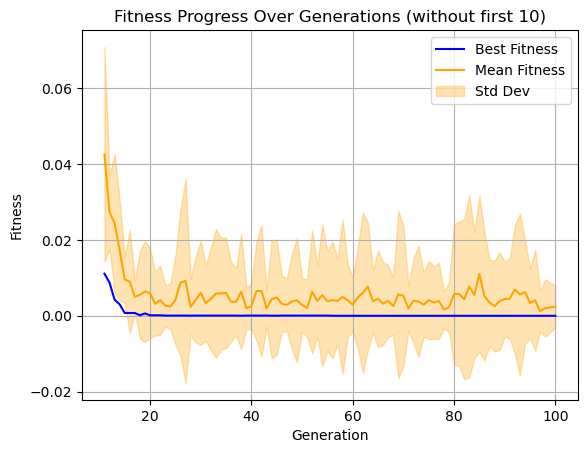


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 0.028099
Generation 20: Best Fitness = 0.003205
Generation 30: Best Fitness = 0.000214
Generation 40: Best Fitness = 0.000081
Generation 50: Best Fitness = 0.000081
Generation 60: Best Fitness = 0.000081
Generation 70: Best Fitness = 0.000034
Generation 80: Best Fitness = 0.000034
Generation 90: Best Fitness = 0.000019
Generation 100: Best Fitness = 0.000015
Best solution: [-0.00217921 -0.0027097   0.00113161]
Best value: 1.4652519593038732e-05


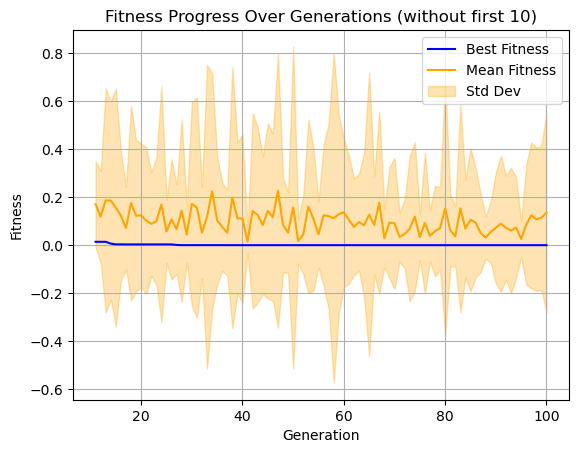


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 0.018945
Generation 20: Best Fitness = 0.001402
Generation 30: Best Fitness = 0.000692
Generation 40: Best Fitness = 0.000175
Generation 50: Best Fitness = 0.000117
Generation 60: Best Fitness = 0.000117
Generation 70: Best Fitness = 0.000117
Generation 80: Best Fitness = 0.000104
Generation 90: Best Fitness = 0.000104
Generation 100: Best Fitness = 0.000047
Best solution: [-0.00646066  0.00203019  0.00080099]
Best value: 4.714494123419394e-05


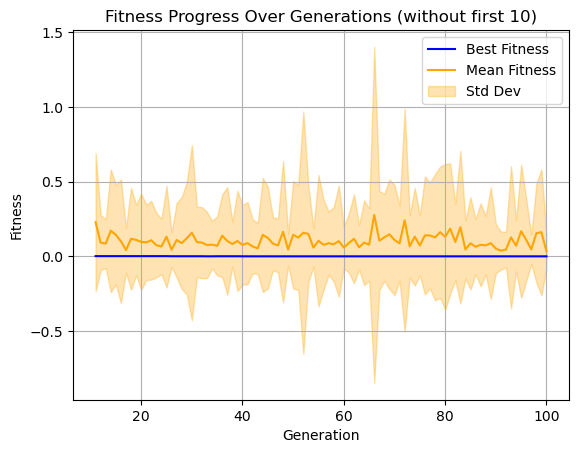


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 0.005923
Generation 20: Best Fitness = 0.003589
Generation 30: Best Fitness = 0.000090
Generation 40: Best Fitness = 0.000090
Generation 50: Best Fitness = 0.000090
Generation 60: Best Fitness = 0.000090
Generation 70: Best Fitness = 0.000022
Generation 80: Best Fitness = 0.000022
Generation 90: Best Fitness = 0.000018
Generation 100: Best Fitness = 0.000018
Best solution: [ 2.02524679e-05 -3.45364036e-03 -1.74417921e-03]
Best value: 1.801236417064625e-05


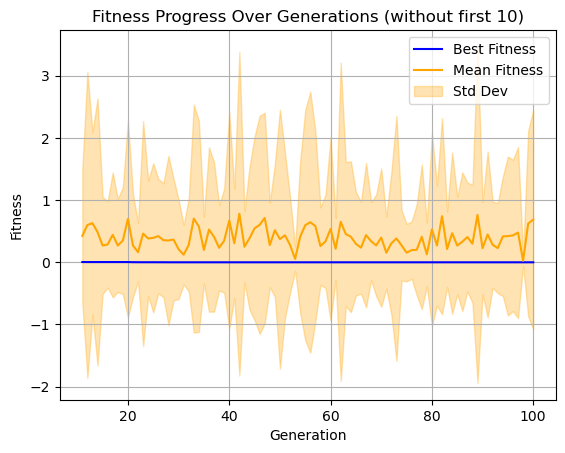


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 0.011593
Generation 20: Best Fitness = 0.001412
Generation 30: Best Fitness = 0.001074
Generation 40: Best Fitness = 0.001383
Generation 50: Best Fitness = 0.000022
Generation 60: Best Fitness = 0.000022
Generation 70: Best Fitness = 0.000022
Generation 80: Best Fitness = 0.000022
Generation 90: Best Fitness = 0.000022
Generation 100: Best Fitness = 0.000022
Best solution: [ 0.00467236  0.0003023  -0.00035683]
Best value: 2.2176984239178073e-05


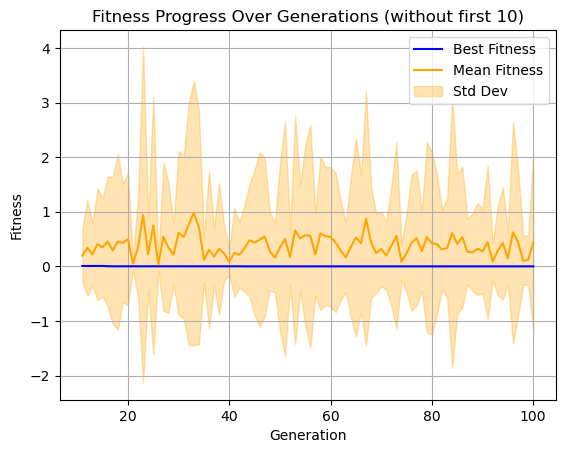


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 0.000341
Generation 20: Best Fitness = 0.000173
Generation 30: Best Fitness = 0.000034
Generation 40: Best Fitness = 0.000020
Generation 50: Best Fitness = 0.000020
Generation 60: Best Fitness = 0.000007
Generation 70: Best Fitness = 0.000007
Generation 80: Best Fitness = 0.000003
Generation 90: Best Fitness = 0.000003
Generation 100: Best Fitness = 0.000003
Best solution: [-0.00166445  0.00011028  0.00019626]
Best value: 2.859598407500741e-06


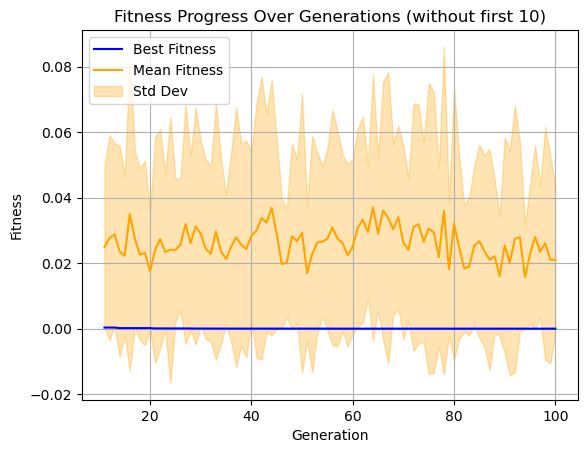


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 0.007411
Generation 20: Best Fitness = 0.001981
Generation 30: Best Fitness = 0.000854
Generation 40: Best Fitness = 0.001349
Generation 50: Best Fitness = 0.002797
Generation 60: Best Fitness = 0.001074
Generation 70: Best Fitness = 0.000483
Generation 80: Best Fitness = 0.000478
Generation 90: Best Fitness = 0.000816
Generation 100: Best Fitness = 0.000795
Best solution: [-0.01884677  0.02038446  0.0035103 ]
Best value: 0.0007953711208163402


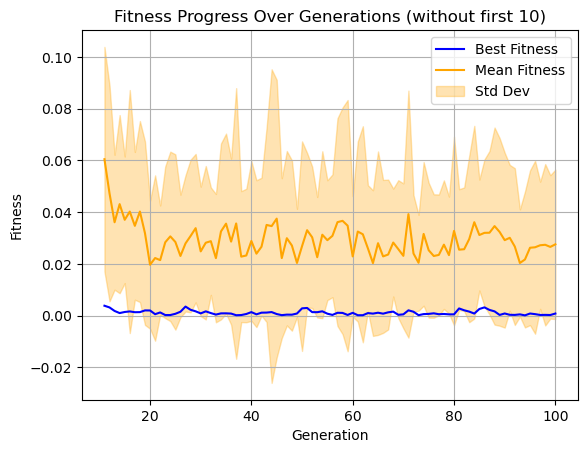


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 0.010572
Generation 20: Best Fitness = 0.006632
Generation 30: Best Fitness = 0.000869
Generation 40: Best Fitness = 0.000869
Generation 50: Best Fitness = 0.000761
Generation 60: Best Fitness = 0.000761
Generation 70: Best Fitness = 0.000535
Generation 80: Best Fitness = 0.000535
Generation 90: Best Fitness = 0.000535
Generation 100: Best Fitness = 0.000535
Best solution: [ 0.00456956 -0.0215616   0.00494055]
Best value: 0.0005346015990998164


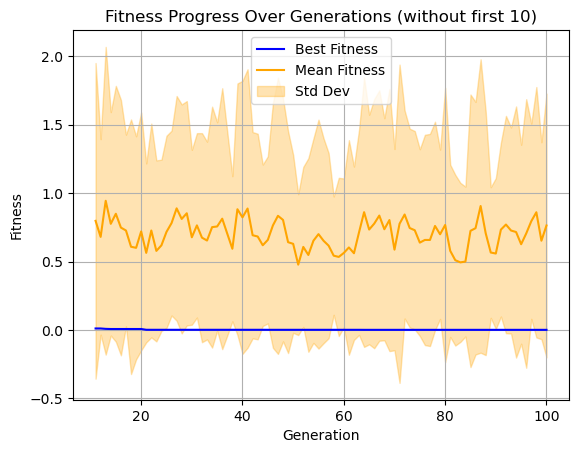


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 0.008711
Generation 20: Best Fitness = 0.029797
Generation 30: Best Fitness = 0.006586
Generation 40: Best Fitness = 0.019639
Generation 50: Best Fitness = 0.033820
Generation 60: Best Fitness = 0.024672
Generation 70: Best Fitness = 0.014515
Generation 80: Best Fitness = 0.035846
Generation 90: Best Fitness = 0.034748
Generation 100: Best Fitness = 0.067496
Best solution: [ 0.16944245  0.0748102  -0.12881955]
Best value: 0.06749626374241849


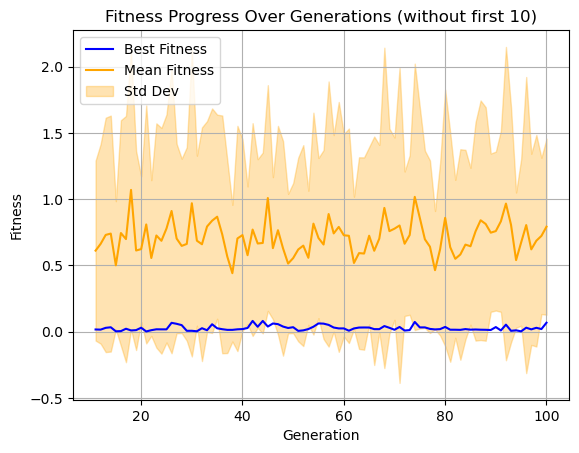


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 0.015259
Generation 20: Best Fitness = 0.004426
Generation 30: Best Fitness = 0.004426
Generation 40: Best Fitness = 0.002736
Generation 50: Best Fitness = 0.002736
Generation 60: Best Fitness = 0.002175
Generation 70: Best Fitness = 0.002175
Generation 80: Best Fitness = 0.000455
Generation 90: Best Fitness = 0.000455
Generation 100: Best Fitness = 0.000455
Best solution: [ 0.00791792 -0.00294436  0.01385633]
Best value: 0.00045535823287867067


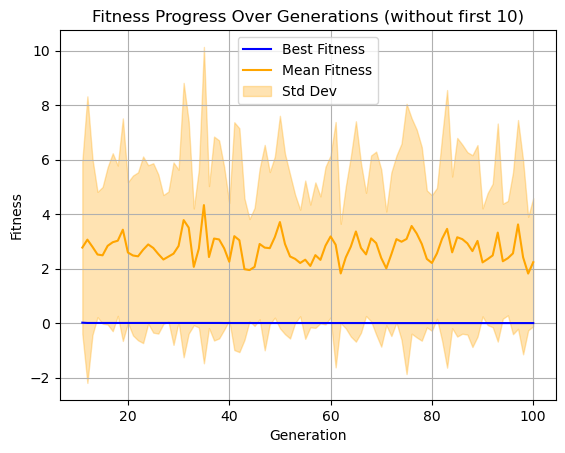


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 0.003799
Generation 20: Best Fitness = 0.099462
Generation 30: Best Fitness = 0.143124
Generation 40: Best Fitness = 0.133013
Generation 50: Best Fitness = 0.114827
Generation 60: Best Fitness = 0.075410
Generation 70: Best Fitness = 0.093589
Generation 80: Best Fitness = 0.088664
Generation 90: Best Fitness = 0.092504
Generation 100: Best Fitness = 0.006020
Best solution: [ 0.07093187 -0.03048748  0.00546141]
Best value: 0.006020470819289772


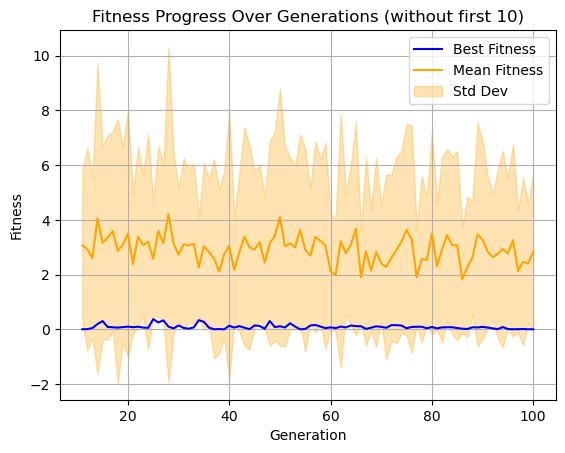


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 0.001646
Generation 20: Best Fitness = 0.000483
Generation 30: Best Fitness = 0.000130
Generation 40: Best Fitness = 0.000130
Generation 50: Best Fitness = 0.000130
Generation 60: Best Fitness = 0.000059
Generation 70: Best Fitness = 0.000059
Generation 80: Best Fitness = 0.000059
Generation 90: Best Fitness = 0.000059
Generation 100: Best Fitness = 0.000059
Best solution: [-0.0063076  -0.00398599  0.0013169 ]
Best value: 5.914240706099876e-05


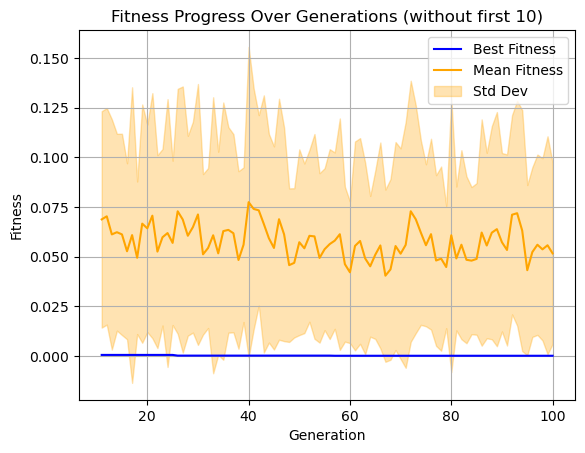


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 0.011389
Generation 20: Best Fitness = 0.001577
Generation 30: Best Fitness = 0.001030
Generation 40: Best Fitness = 0.001968
Generation 50: Best Fitness = 0.008214
Generation 60: Best Fitness = 0.003344
Generation 70: Best Fitness = 0.007173
Generation 80: Best Fitness = 0.005819
Generation 90: Best Fitness = 0.002319
Generation 100: Best Fitness = 0.001775
Best solution: [-0.03611972 -0.01700841 -0.00951041]
Best value: 0.0017748159061167037


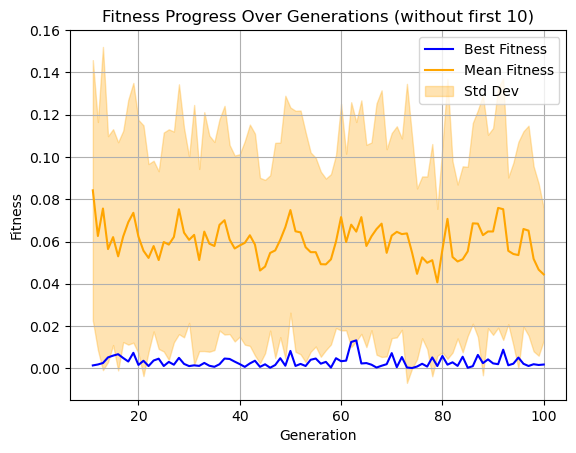


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 0.028394
Generation 20: Best Fitness = 0.021408
Generation 30: Best Fitness = 0.009177
Generation 40: Best Fitness = 0.006939
Generation 50: Best Fitness = 0.006939
Generation 60: Best Fitness = 0.006939
Generation 70: Best Fitness = 0.006939
Generation 80: Best Fitness = 0.006939
Generation 90: Best Fitness = 0.002987
Generation 100: Best Fitness = 0.002987
Best solution: [0.02720277 0.01604227 0.03153972]
Best value: 0.0029868534901976856


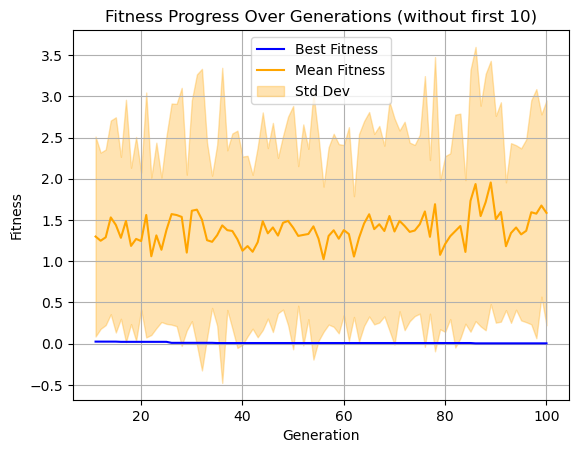


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 0.012871
Generation 20: Best Fitness = 0.169209
Generation 30: Best Fitness = 0.057835
Generation 40: Best Fitness = 0.071152
Generation 50: Best Fitness = 0.134309
Generation 60: Best Fitness = 0.018774
Generation 70: Best Fitness = 0.254605
Generation 80: Best Fitness = 0.101570
Generation 90: Best Fitness = 0.031725
Generation 100: Best Fitness = 0.045903
Best solution: [ 0.06743381 -0.07588582 -0.1334105 ]
Best value: 0.045902699666591086


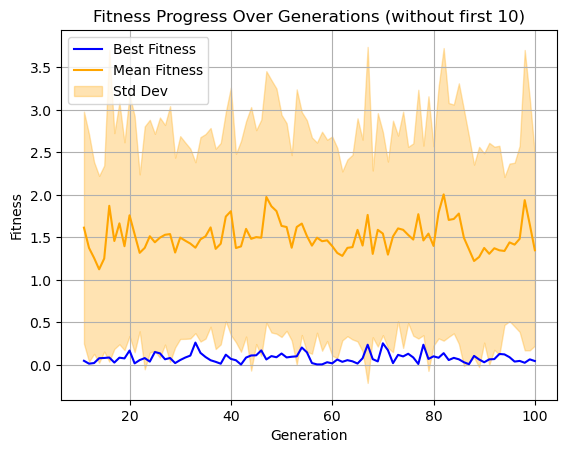


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 0.289238
Generation 20: Best Fitness = 0.073759
Generation 30: Best Fitness = 0.063080
Generation 40: Best Fitness = 0.013494
Generation 50: Best Fitness = 0.013494
Generation 60: Best Fitness = 0.013494
Generation 70: Best Fitness = 0.013494
Generation 80: Best Fitness = 0.013494
Generation 90: Best Fitness = 0.013494
Generation 100: Best Fitness = 0.013494
Best solution: [-0.03911918  0.09328992 -0.04038009]
Best value: 0.013494422632821444


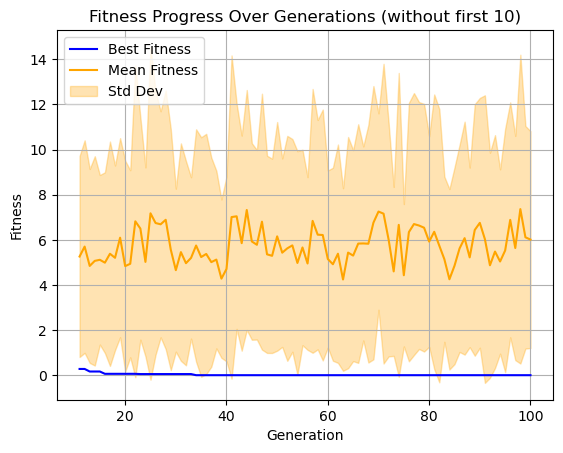


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 0.119650
Generation 20: Best Fitness = 0.244345
Generation 30: Best Fitness = 0.361802
Generation 40: Best Fitness = 0.299051
Generation 50: Best Fitness = 0.116429
Generation 60: Best Fitness = 0.211128
Generation 70: Best Fitness = 0.216325
Generation 80: Best Fitness = 0.274711
Generation 90: Best Fitness = 0.070352
Generation 100: Best Fitness = 0.454003
Best solution: [ 0.04848763 -0.52699448 -0.29489757]
Best value: 0.45400338333909673


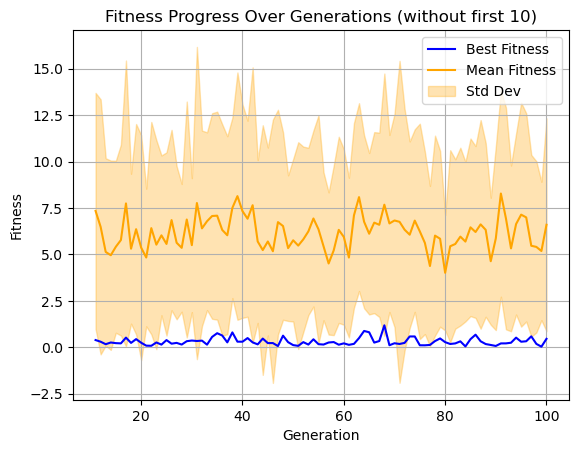

In [5]:
results_square = []

for crossover_rate in crossover_rates:
    for mutation_rate in mutation_rates:
        for mutation_std in mutation_stds:
            for elitism in elitism_options:
                print(f"\nGA with crossover_rate={crossover_rate}, mutation_rate={mutation_rate}, mutation_std={mutation_std}, elitism={elitism}")
                
                ga = GeneticAlgorithm(
                    objective_function=simple_quadratic_function,
                    dimension=3,
                    population_size=50, 
                    crossover_rate=crossover_rate, 
                    mutation_rate=mutation_rate, 
                    mutation_std=mutation_std, 
                    bounds=(-5.12, 5.12), 
                    elitism=elitism
                )
                best_solution, best_value = ga.evolve(generations=100)
                
                results_square.append({
                    'crossover_rate': crossover_rate,
                    'mutation_rate': mutation_rate,
                    'mutation_std': mutation_std,
                    'elitism': elitism,
                    'best_value': best_value
                })
                
                print("Best solution:", best_solution)
                print("Best value:", best_value)
                ga.plot_fitness_progress()
                
results_square_df = pd.DataFrame(results_square)

In [6]:
results_square_df

crossover_rate  mutation_rate  mutation_std  elitism    best_value
0              0.1            0.1           0.1     True  1.158119e-05
1              0.1            0.1           0.1    False  4.362628e-06
2              0.1            0.1           0.5     True  6.734678e-06
3              0.1            0.1           0.5    False  3.385062e-05
4              0.1            0.1           1.0     True  4.619116e-06
5              0.1            0.1           1.0    False  3.378969e-07
6              0.1            0.5           0.1     True  5.132699e-05
7              0.1            0.5           0.1    False  1.115835e-03
8              0.1            0.5           0.5     True  1.193342e-04
9              0.1            0.5           0.5    False  5.582888e-03
10             0.1            0.5           1.0     True  1.376053e-03
11             0.1            0.5           1.0    False  2.157386e-04
12             0.1            0.9           0.1     True  1.173330e-04
13             0.1            0.9           0.1    False  1.514469e-03
14             0.1            0.9           0.5     True  3.715322e-03
15             0.1            0.9           0.5    False  8.173116e-02
16             0.1            0.9           1.0     True  2.020491e-02
17             0.1            0.9           1.0    False  2.223536e-01
18             0.5            0.1           0.1     True  2.527753e-06
19             0.5            0.1           0.1    False  1.836139e-06
20             0.5            0.1           0.5     True  4.996709e-05
21             0.5            0.1           0.5    False  2.814215e-06
22             0.5            0.1           1.0     True  3.026874e-04
23             0.5            0.1           1.0    False  1.025989e-04
24             0.5            0.5           0.1     True  6.915456e-05
25             0.5            0.5           0.1    False  8.510775e-04
26             0.5            0.5           0.5     True  5.934378e-04
27             0.5            0.5           0.5    False  3.839787e-02
28             0.5            0.5           1.0     True  9.210768e-04
29             0.5            0.5           1.0    False  6.134816e-02
30             0.5            0.9           0.1     True  1.166274e-04
31             0.5            0.9           0.1    False  8.685737e-04
32             0.5            0.9           0.5     True  1.354010e-03
33             0.5            0.9           0.5    False  1.071307e-01
34             0.5            0.9           1.0     True  1.075024e-02
35             0.5            0.9           1.0    False  3.039293e-02
36             0.9            0.1           0.1     True  1.431290e-07
37             0.9            0.1           0.1    False  2.366659e-07
38             0.9            0.1           0.5     True  1.465252e-05
39             0.9            0.1           0.5    False  4.714494e-05
40             0.9            0.1           1.0     True  1.801236e-05
41             0.9            0.1           1.0    False  2.217698e-05
42             0.9            0.5           0.1     True  2.859598e-06
43             0.9            0.5           0.1    False  7.953711e-04
44             0.9            0.5           0.5     True  5.346016e-04
45             0.9            0.5           0.5    False  6.749626e-02
46             0.9            0.5           1.0     True  4.553582e-04
47             0.9            0.5           1.0    False  6.020471e-03
48             0.9            0.9           0.1     True  5.914241e-05
49             0.9            0.9           0.1    False  1.774816e-03
50             0.9            0.9           0.5     True  2.986853e-03
51             0.9            0.9           0.5    False  4.590270e-02
52             0.9            0.9           1.0     True  1.349442e-02
53             0.9            0.9           1.0    False  4.540034e-01

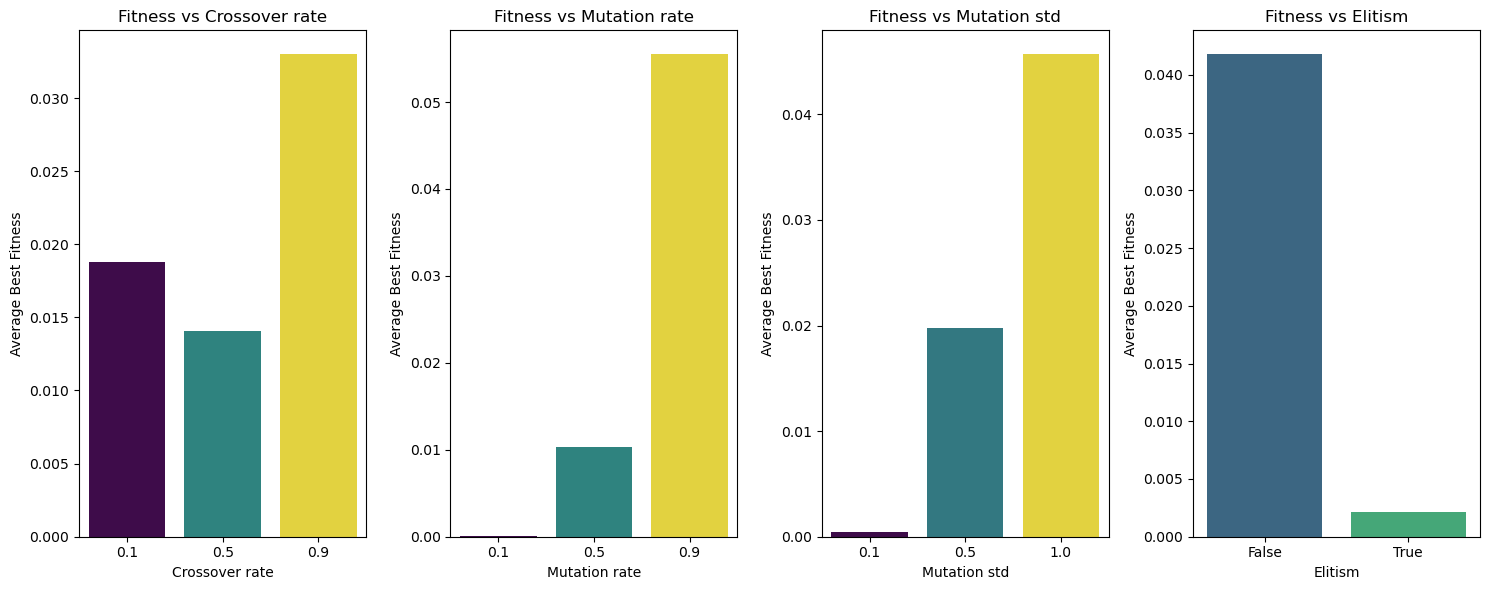

In [7]:
params = ['crossover_rate', 'mutation_rate', 'mutation_std', 'elitism']

plt.figure(figsize=(15, 6))

for i, param in enumerate(params, 1):
    plt.subplot(1, 4, i)
    
    grouped = results_square_df.groupby(param)['best_value'].mean().reset_index()
    
    if param == 'elitism':
        grouped[param] = grouped[param].astype(str)
    
    sns.barplot(x=param, y='best_value', data=grouped, palette='viridis', hue=param, legend=None)
    plt.xlabel(param.replace('_', ' ').capitalize())
    plt.ylabel('Average Best Fitness')
    plt.title(f'Fitness vs {param.replace("_", " ").capitalize()}')

plt.tight_layout()
plt.show()

### **Rastrigin function**


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 7.828301
Generation 20: Best Fitness = 6.078693
Generation 30: Best Fitness = 5.982956
Generation 40: Best Fitness = 5.976904
Generation 50: Best Fitness = 5.974793
Generation 60: Best Fitness = 5.970386
Generation 70: Best Fitness = 5.970283
Generation 80: Best Fitness = 5.970283
Generation 90: Best Fitness = 5.970283
Generation 100: Best Fitness = 5.970246
Generation 110: Best Fitness = 5.970072
Generation 120: Best Fitness = 5.970049
Generation 130: Best Fitness = 5.970049
Generation 140: Best Fitness = 5.970049
Generation 150: Best Fitness = 5.969931
Generation 160: Best Fitness = 5.969931
Generation 170: Best Fitness = 5.969931
Generation 180: Best Fitness = 5.969884
Generation 190: Best Fitness = 5.969884
Generation 200: Best Fitness = 5.969884
Best solution: [ 5.32055351e-04 -9.95160562e-01  1.64393224e-05 -1.99038147e+00
  9.95323666e-01]
Best value: 5.969883624338863


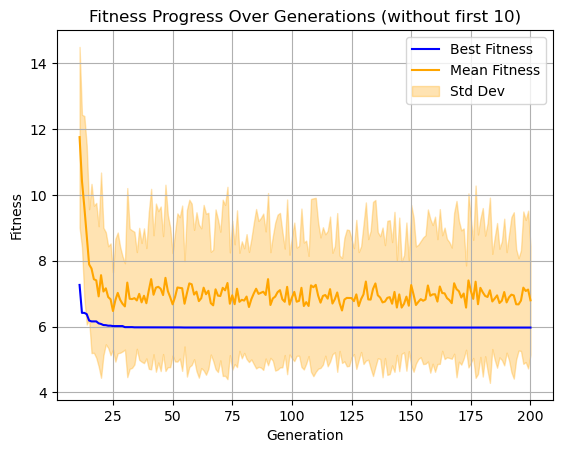


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 10.415091
Generation 20: Best Fitness = 6.035598
Generation 30: Best Fitness = 5.984728
Generation 40: Best Fitness = 5.973514
Generation 50: Best Fitness = 5.972886
Generation 60: Best Fitness = 5.970369
Generation 70: Best Fitness = 5.970369
Generation 80: Best Fitness = 5.970369
Generation 90: Best Fitness = 5.970369
Generation 100: Best Fitness = 5.970075
Generation 110: Best Fitness = 5.970031
Generation 120: Best Fitness = 5.969832
Generation 130: Best Fitness = 5.969816
Generation 140: Best Fitness = 5.969816
Generation 150: Best Fitness = 5.969816
Generation 160: Best Fitness = 5.969816
Generation 170: Best Fitness = 5.969816
Generation 180: Best Fitness = 5.969816
Generation 190: Best Fitness = 5.969811
Generation 200: Best Fitness = 5.969811
Best solution: [-1.41448939e-04 -3.52862961e-04 -9.94826957e-01  1.98989910e+00
  9.95344619e-01]
Best value: 5.969810991656097


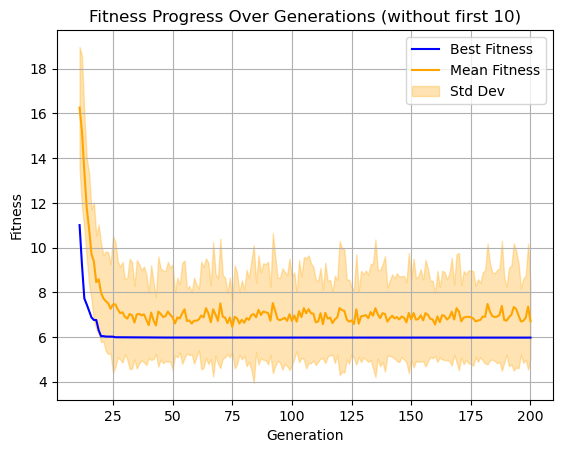


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 8.293116
Generation 20: Best Fitness = 3.171166
Generation 30: Best Fitness = 1.259786
Generation 40: Best Fitness = 1.223566
Generation 50: Best Fitness = 0.235566
Generation 60: Best Fitness = 0.029089
Generation 70: Best Fitness = 0.020436
Generation 80: Best Fitness = 0.020436
Generation 90: Best Fitness = 0.015781
Generation 100: Best Fitness = 0.015781
Generation 110: Best Fitness = 0.011122
Generation 120: Best Fitness = 0.007342
Generation 130: Best Fitness = 0.007342
Generation 140: Best Fitness = 0.005302
Generation 150: Best Fitness = 0.004333
Generation 160: Best Fitness = 0.000332
Generation 170: Best Fitness = 0.000220
Generation 180: Best Fitness = 0.000220
Generation 190: Best Fitness = 0.000220
Generation 200: Best Fitness = 0.000220
Best solution: [-1.13905224e-04  4.34154963e-04 -6.50743575e-04 -6.00659827e-05
 -6.91354766e-04]
Best value: 0.000219522832338725

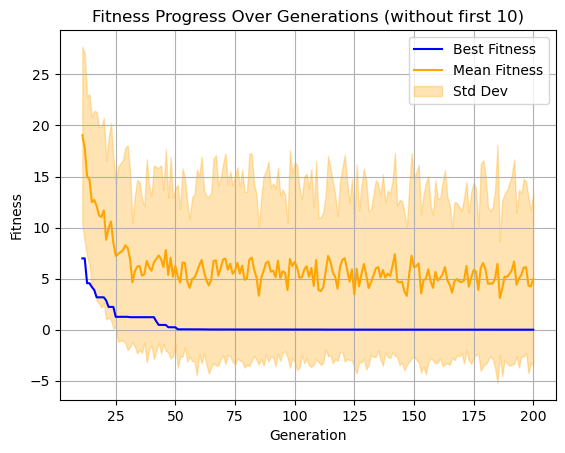


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 12.923173
Generation 20: Best Fitness = 4.376638
Generation 30: Best Fitness = 3.118151
Generation 40: Best Fitness = 0.338515
Generation 50: Best Fitness = 0.163452
Generation 60: Best Fitness = 0.100237
Generation 70: Best Fitness = 0.067804
Generation 80: Best Fitness = 0.057090
Generation 90: Best Fitness = 0.031992
Generation 100: Best Fitness = 0.031992
Generation 110: Best Fitness = 0.031992
Generation 120: Best Fitness = 0.012105
Generation 130: Best Fitness = 0.003636
Generation 140: Best Fitness = 0.003636
Generation 150: Best Fitness = 0.003636
Generation 160: Best Fitness = 0.002139
Generation 170: Best Fitness = 0.002139
Generation 180: Best Fitness = 0.002139
Generation 190: Best Fitness = 0.002139
Generation 200: Best Fitness = 0.002139
Best solution: [0.00292483 0.00066062 0.0001955  0.00092515 0.00094819]
Best value: 0.0021394655060475998


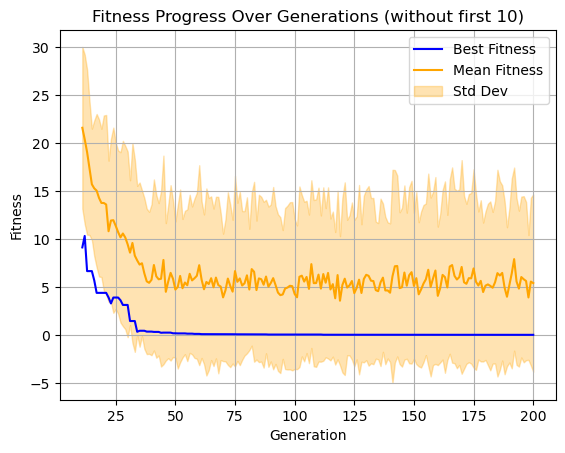


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 7.687712
Generation 20: Best Fitness = 3.669263
Generation 30: Best Fitness = 2.738826
Generation 40: Best Fitness = 0.349278
Generation 50: Best Fitness = 0.046182
Generation 60: Best Fitness = 0.046182
Generation 70: Best Fitness = 0.022794
Generation 80: Best Fitness = 0.011267
Generation 90: Best Fitness = 0.007384
Generation 100: Best Fitness = 0.001540
Generation 110: Best Fitness = 0.001538
Generation 120: Best Fitness = 0.001538
Generation 130: Best Fitness = 0.001523
Generation 140: Best Fitness = 0.001523
Generation 150: Best Fitness = 0.001523
Generation 160: Best Fitness = 0.001523
Generation 170: Best Fitness = 0.000858
Generation 180: Best Fitness = 0.000858
Generation 190: Best Fitness = 0.000858
Generation 200: Best Fitness = 0.000858
Best solution: [-1.27699159e-03 -4.60472540e-04 -8.16267580e-05  1.53131130e-03
  3.63559788e-04]
Best value: 0.000858337121265151

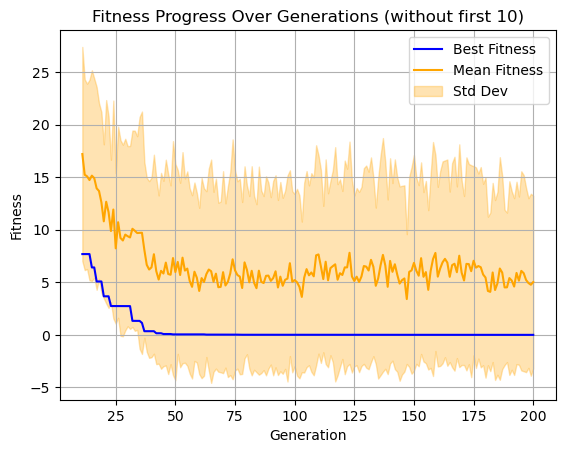


GA with crossover_rate=0.1, mutation_rate=0.1, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 15.729009
Generation 20: Best Fitness = 6.241006
Generation 30: Best Fitness = 2.117730
Generation 40: Best Fitness = 2.215639
Generation 50: Best Fitness = 1.115926
Generation 60: Best Fitness = 0.643461
Generation 70: Best Fitness = 0.264051
Generation 80: Best Fitness = 0.046262
Generation 90: Best Fitness = 0.046262
Generation 100: Best Fitness = 0.029622
Generation 110: Best Fitness = 0.022368
Generation 120: Best Fitness = 0.022368
Generation 130: Best Fitness = 0.017413
Generation 140: Best Fitness = 0.022368
Generation 150: Best Fitness = 0.022368
Generation 160: Best Fitness = 0.022368
Generation 170: Best Fitness = 0.020704
Generation 180: Best Fitness = 0.020473
Generation 190: Best Fitness = 0.017850
Generation 200: Best Fitness = 0.013821
Best solution: [ 0.00015407  0.00306435 -0.00343378 -0.00312321 -0.00622207]
Best value: 0.013821476550496925


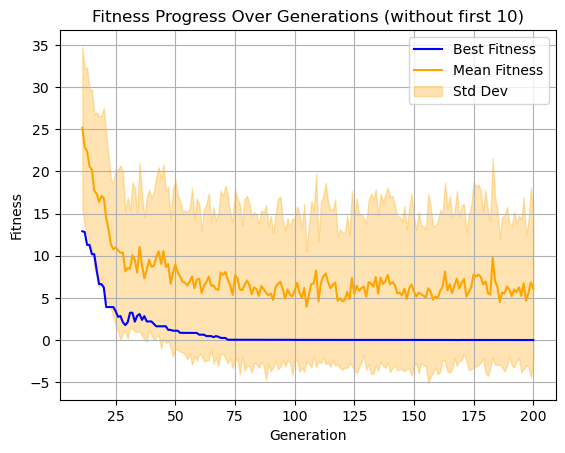


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 8.672663
Generation 20: Best Fitness = 7.139865
Generation 30: Best Fitness = 7.139865
Generation 40: Best Fitness = 7.139865
Generation 50: Best Fitness = 7.087811
Generation 60: Best Fitness = 7.087811
Generation 70: Best Fitness = 7.015010
Generation 80: Best Fitness = 6.998450
Generation 90: Best Fitness = 6.997238
Generation 100: Best Fitness = 6.997238
Generation 110: Best Fitness = 6.982741
Generation 120: Best Fitness = 6.982741
Generation 130: Best Fitness = 6.982741
Generation 140: Best Fitness = 6.982741
Generation 150: Best Fitness = 6.982741
Generation 160: Best Fitness = 6.982741
Generation 170: Best Fitness = 6.976933
Generation 180: Best Fitness = 6.976933
Generation 190: Best Fitness = 6.976933
Generation 200: Best Fitness = 6.976933
Best solution: [-1.98952879e+00 -1.59784609e-03  9.88844703e-01  9.93704375e-01
 -9.90483802e-01]
Best value: 6.97693345937013


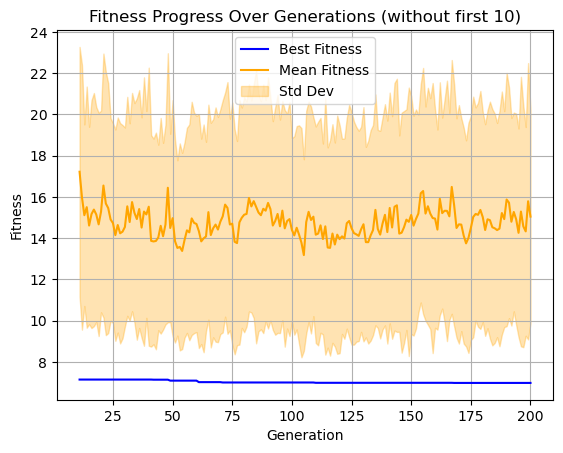


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 5.566266
Generation 20: Best Fitness = 3.389859
Generation 30: Best Fitness = 2.470672
Generation 40: Best Fitness = 3.584505
Generation 50: Best Fitness = 2.948952
Generation 60: Best Fitness = 2.603949
Generation 70: Best Fitness = 2.700561
Generation 80: Best Fitness = 2.676053
Generation 90: Best Fitness = 2.176334
Generation 100: Best Fitness = 2.788908
Generation 110: Best Fitness = 2.570109
Generation 120: Best Fitness = 2.620314
Generation 130: Best Fitness = 2.404583
Generation 140: Best Fitness = 2.256018
Generation 150: Best Fitness = 2.282644
Generation 160: Best Fitness = 2.486506
Generation 170: Best Fitness = 2.702053
Generation 180: Best Fitness = 2.578527
Generation 190: Best Fitness = 2.919483
Generation 200: Best Fitness = 2.761284
Best solution: [ 0.00307741  1.00568161 -1.00254698  0.05327662  0.02994306]
Best value: 2.7612843023815756


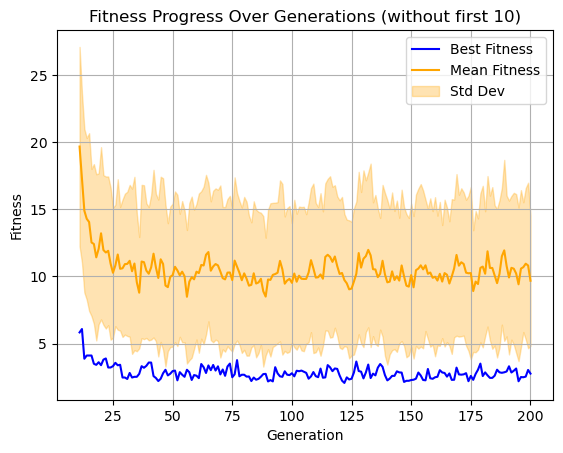


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 10.721894
Generation 20: Best Fitness = 7.830472
Generation 30: Best Fitness = 6.726678
Generation 40: Best Fitness = 6.726678
Generation 50: Best Fitness = 6.726678
Generation 60: Best Fitness = 5.949752
Generation 70: Best Fitness = 5.949752
Generation 80: Best Fitness = 5.667149
Generation 90: Best Fitness = 4.351325
Generation 100: Best Fitness = 4.005754
Generation 110: Best Fitness = 4.005754
Generation 120: Best Fitness = 2.595699
Generation 130: Best Fitness = 2.595699
Generation 140: Best Fitness = 2.595699
Generation 150: Best Fitness = 2.595699
Generation 160: Best Fitness = 2.595699
Generation 170: Best Fitness = 2.595699
Generation 180: Best Fitness = 1.722394
Generation 190: Best Fitness = 1.722394
Generation 200: Best Fitness = 0.933825
Best solution: [-0.02381363  0.03415235  0.04411878 -0.02843163 -0.01545522]
Best value: 0.9338252942663843


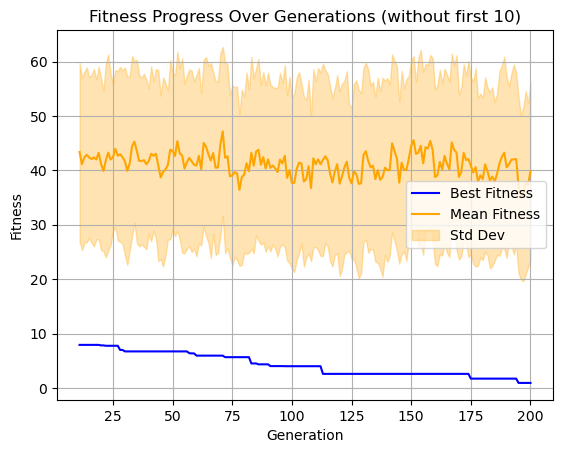


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 19.591926
Generation 20: Best Fitness = 10.846810
Generation 30: Best Fitness = 10.659407
Generation 40: Best Fitness = 19.534121
Generation 50: Best Fitness = 11.628007
Generation 60: Best Fitness = 16.261915
Generation 70: Best Fitness = 12.948174
Generation 80: Best Fitness = 10.427913
Generation 90: Best Fitness = 11.582570
Generation 100: Best Fitness = 16.045864
Generation 110: Best Fitness = 10.262696
Generation 120: Best Fitness = 14.939087
Generation 130: Best Fitness = 8.895049
Generation 140: Best Fitness = 8.799550
Generation 150: Best Fitness = 7.089621
Generation 160: Best Fitness = 12.699528
Generation 170: Best Fitness = 9.422661
Generation 180: Best Fitness = 12.308143
Generation 190: Best Fitness = 10.956040
Generation 200: Best Fitness = 6.679431
Best solution: [ 0.94367438 -1.0322539  -0.9693116   0.94169653  1.02895437]
Best value: 6.67943072129453


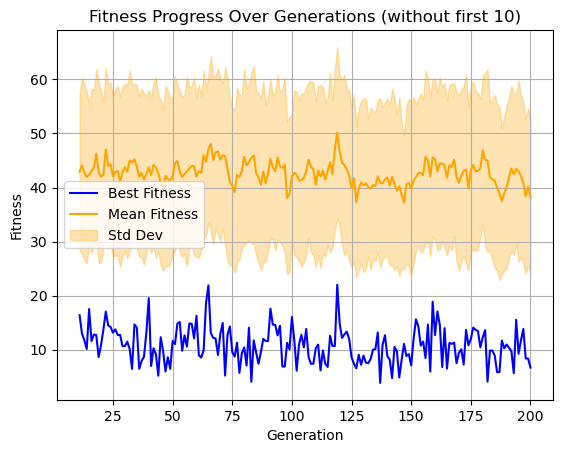


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 9.576040
Generation 20: Best Fitness = 8.997311
Generation 30: Best Fitness = 7.144959
Generation 40: Best Fitness = 7.135969
Generation 50: Best Fitness = 6.718188
Generation 60: Best Fitness = 6.718188
Generation 70: Best Fitness = 6.718188
Generation 80: Best Fitness = 6.718188
Generation 90: Best Fitness = 6.718188
Generation 100: Best Fitness = 6.718188
Generation 110: Best Fitness = 6.718188
Generation 120: Best Fitness = 6.718188
Generation 130: Best Fitness = 6.718188
Generation 140: Best Fitness = 5.648199
Generation 150: Best Fitness = 5.513098
Generation 160: Best Fitness = 5.513098
Generation 170: Best Fitness = 4.850527
Generation 180: Best Fitness = 4.850527
Generation 190: Best Fitness = 4.850527
Generation 200: Best Fitness = 4.850527
Best solution: [-1.01253254 -1.02230874  1.03130522  0.04012779 -0.97459916]
Best value: 4.8505268384531846


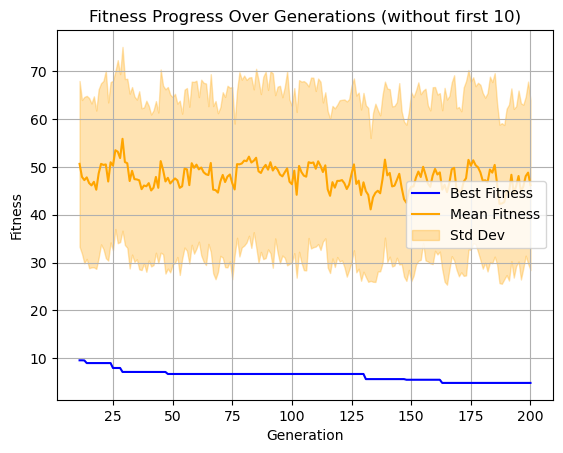


GA with crossover_rate=0.1, mutation_rate=0.5, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 12.729984
Generation 20: Best Fitness = 16.417308
Generation 30: Best Fitness = 17.521339
Generation 40: Best Fitness = 14.574687
Generation 50: Best Fitness = 14.786525
Generation 60: Best Fitness = 13.244101
Generation 70: Best Fitness = 19.561321
Generation 80: Best Fitness = 13.129840
Generation 90: Best Fitness = 16.554610
Generation 100: Best Fitness = 13.289014
Generation 110: Best Fitness = 11.173426
Generation 120: Best Fitness = 8.362218
Generation 130: Best Fitness = 22.312922
Generation 140: Best Fitness = 8.782075
Generation 150: Best Fitness = 11.199480
Generation 160: Best Fitness = 13.638843
Generation 170: Best Fitness = 18.192545
Generation 180: Best Fitness = 14.778127
Generation 190: Best Fitness = 22.979535
Generation 200: Best Fitness = 22.678524
Best solution: [-0.21151828 -0.95944217  1.82927775  1.14250951 -0.02868415]
Best value: 22.678524244304057


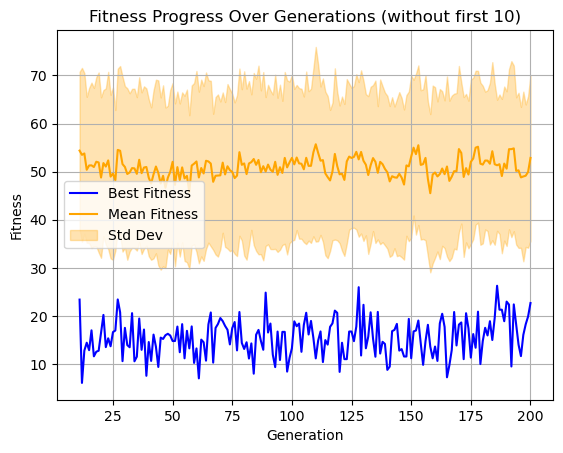


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 16.236250
Generation 20: Best Fitness = 14.087459
Generation 30: Best Fitness = 13.435191
Generation 40: Best Fitness = 13.387879
Generation 50: Best Fitness = 13.387879
Generation 60: Best Fitness = 13.387879
Generation 70: Best Fitness = 13.387879
Generation 80: Best Fitness = 13.387879
Generation 90: Best Fitness = 13.387879
Generation 100: Best Fitness = 13.387879
Generation 110: Best Fitness = 13.297953
Generation 120: Best Fitness = 13.297953
Generation 130: Best Fitness = 13.169957
Generation 140: Best Fitness = 13.169957
Generation 150: Best Fitness = 13.169957
Generation 160: Best Fitness = 13.169957
Generation 170: Best Fitness = 13.169957
Generation 180: Best Fitness = 13.169957
Generation 190: Best Fitness = 13.169957
Generation 200: Best Fitness = 13.169957
Best solution: [ 0.99843322  1.98028404 -1.99388375  1.97695924  0.0300412 ]
Best value: 13.169957083063949


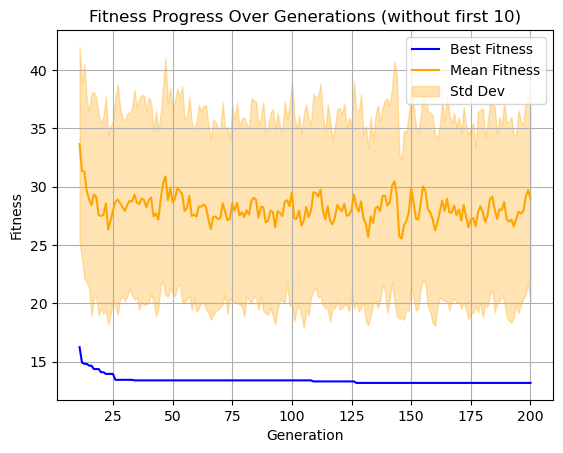


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 11.241106
Generation 20: Best Fitness = 6.149532
Generation 30: Best Fitness = 6.660201
Generation 40: Best Fitness = 4.604048
Generation 50: Best Fitness = 5.870917
Generation 60: Best Fitness = 6.036072
Generation 70: Best Fitness = 4.988390
Generation 80: Best Fitness = 3.843087
Generation 90: Best Fitness = 4.555379
Generation 100: Best Fitness = 5.289201
Generation 110: Best Fitness = 5.144332
Generation 120: Best Fitness = 5.140246
Generation 130: Best Fitness = 3.329629
Generation 140: Best Fitness = 3.323993
Generation 150: Best Fitness = 6.637388
Generation 160: Best Fitness = 4.994662
Generation 170: Best Fitness = 7.389309
Generation 180: Best Fitness = 4.761074
Generation 190: Best Fitness = 3.931837
Generation 200: Best Fitness = 6.639949
Best solution: [ 1.00977018  1.04017441 -0.05485563 -0.08601677  0.9167078 ]
Best value: 6.639948611320477


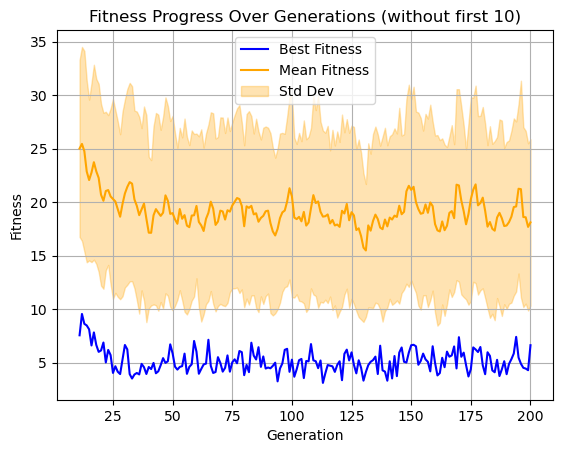


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 12.681034
Generation 20: Best Fitness = 9.583532
Generation 30: Best Fitness = 9.285619
Generation 40: Best Fitness = 9.285619
Generation 50: Best Fitness = 8.805325
Generation 60: Best Fitness = 8.574375
Generation 70: Best Fitness = 5.018536
Generation 80: Best Fitness = 4.840986
Generation 90: Best Fitness = 4.840986
Generation 100: Best Fitness = 4.840986
Generation 110: Best Fitness = 4.840986
Generation 120: Best Fitness = 4.840986
Generation 130: Best Fitness = 4.840986
Generation 140: Best Fitness = 4.840986
Generation 150: Best Fitness = 4.840986
Generation 160: Best Fitness = 4.840986
Generation 170: Best Fitness = 4.840986
Generation 180: Best Fitness = 4.840986
Generation 190: Best Fitness = 4.840986
Generation 200: Best Fitness = 4.840986
Best solution: [-0.0541856   1.08073831  0.03692997  0.03109434  0.08426049]
Best value: 4.840985970898515


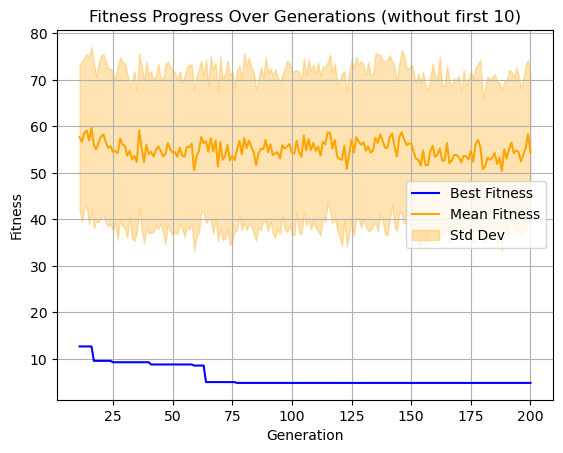


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 19.204095
Generation 20: Best Fitness = 25.093651
Generation 30: Best Fitness = 24.233537
Generation 40: Best Fitness = 15.513478
Generation 50: Best Fitness = 16.396923
Generation 60: Best Fitness = 13.783378
Generation 70: Best Fitness = 24.659220
Generation 80: Best Fitness = 16.062224
Generation 90: Best Fitness = 28.365097
Generation 100: Best Fitness = 17.335442
Generation 110: Best Fitness = 16.026881
Generation 120: Best Fitness = 22.358962
Generation 130: Best Fitness = 12.068755
Generation 140: Best Fitness = 12.358818
Generation 150: Best Fitness = 16.929154
Generation 160: Best Fitness = 16.170531
Generation 170: Best Fitness = 16.902922
Generation 180: Best Fitness = 18.847945
Generation 190: Best Fitness = 22.365945
Generation 200: Best Fitness = 11.390553
Best solution: [ 0.01807372  2.04037632 -0.95537771  2.02986257 -0.08000658]
Best value: 11.390552728934104


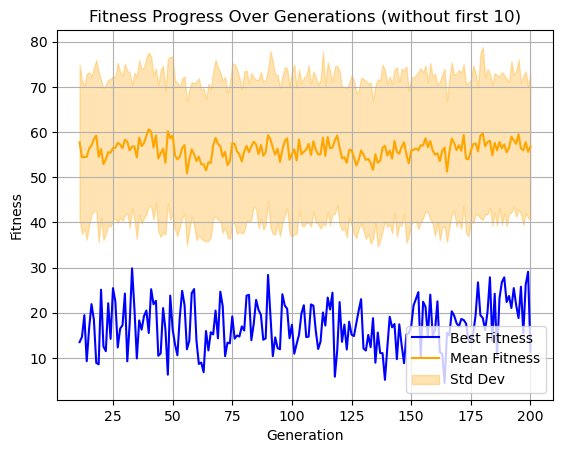


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 19.997481
Generation 20: Best Fitness = 9.903113
Generation 30: Best Fitness = 9.903113
Generation 40: Best Fitness = 9.903113
Generation 50: Best Fitness = 9.903113
Generation 60: Best Fitness = 9.903113
Generation 70: Best Fitness = 9.204523
Generation 80: Best Fitness = 5.375057
Generation 90: Best Fitness = 5.375057
Generation 100: Best Fitness = 5.375057
Generation 110: Best Fitness = 5.375057
Generation 120: Best Fitness = 5.375057
Generation 130: Best Fitness = 5.375057
Generation 140: Best Fitness = 5.375057
Generation 150: Best Fitness = 5.375057
Generation 160: Best Fitness = 5.375057
Generation 170: Best Fitness = 5.375057
Generation 180: Best Fitness = 5.375057
Generation 190: Best Fitness = 5.375057
Generation 200: Best Fitness = 5.375057
Best solution: [-0.0668388   1.00140278  1.00849652 -0.945891   -0.98989267]
Best value: 5.375056873568873


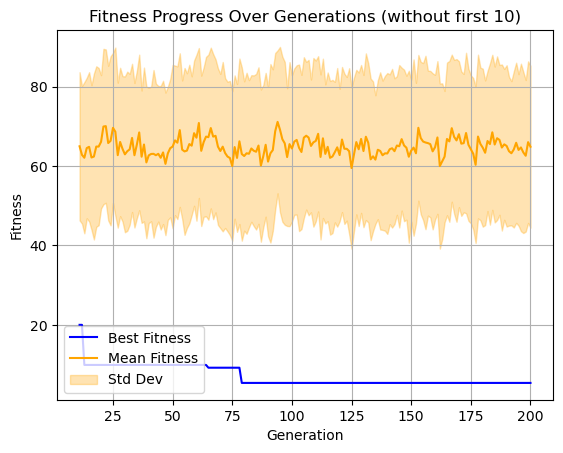


GA with crossover_rate=0.1, mutation_rate=0.9, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 24.838843
Generation 20: Best Fitness = 28.395355
Generation 30: Best Fitness = 28.115385
Generation 40: Best Fitness = 16.505919
Generation 50: Best Fitness = 26.008710
Generation 60: Best Fitness = 29.621780
Generation 70: Best Fitness = 27.319906
Generation 80: Best Fitness = 30.047020
Generation 90: Best Fitness = 19.354022
Generation 100: Best Fitness = 32.033087
Generation 110: Best Fitness = 17.288845
Generation 120: Best Fitness = 20.937802
Generation 130: Best Fitness = 30.411695
Generation 140: Best Fitness = 28.964144
Generation 150: Best Fitness = 11.294574
Generation 160: Best Fitness = 23.261732
Generation 170: Best Fitness = 29.135777
Generation 180: Best Fitness = 32.131019
Generation 190: Best Fitness = 13.770200
Generation 200: Best Fitness = 20.387391
Best solution: [ 1.98932574 -0.02938846  1.09674     2.13596582  0.84194588]
Best value: 20.387391062908193


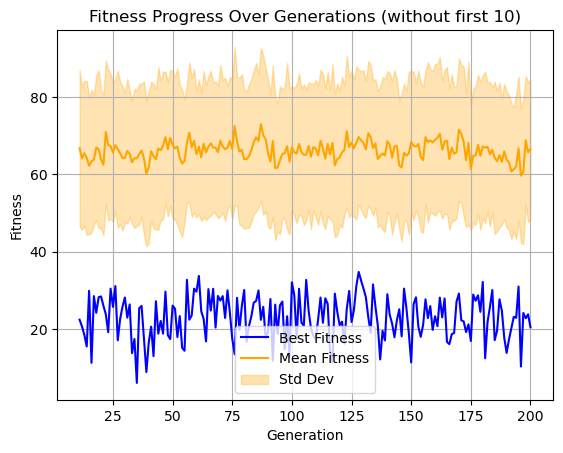


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 8.182123
Generation 20: Best Fitness = 5.152241
Generation 30: Best Fitness = 5.003019
Generation 40: Best Fitness = 4.981681
Generation 50: Best Fitness = 4.975359
Generation 60: Best Fitness = 4.975075
Generation 70: Best Fitness = 4.975075
Generation 80: Best Fitness = 4.975002
Generation 90: Best Fitness = 4.974938
Generation 100: Best Fitness = 4.974934
Generation 110: Best Fitness = 4.974856
Generation 120: Best Fitness = 4.974856
Generation 130: Best Fitness = 4.974803
Generation 140: Best Fitness = 4.974802
Generation 150: Best Fitness = 4.974802
Generation 160: Best Fitness = 4.974801
Generation 170: Best Fitness = 4.974801
Generation 180: Best Fitness = 4.974801
Generation 190: Best Fitness = 4.974798
Generation 200: Best Fitness = 4.974797
Best solution: [-3.17740570e-05  1.98975670e+00  3.18053177e-05  9.95011108e-01
  7.48395804e-05]
Best value: 4.97479709513653


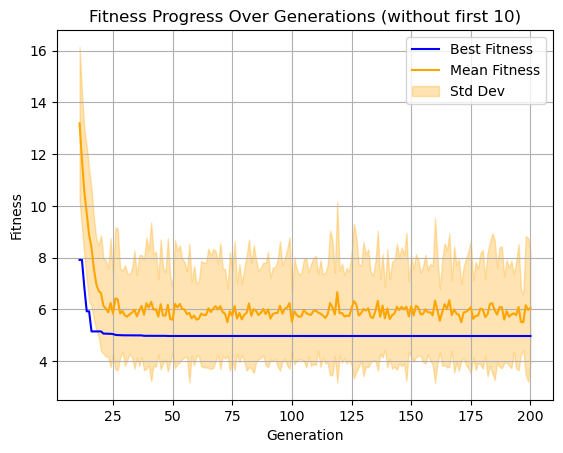


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 5.884798
Generation 20: Best Fitness = 4.035837
Generation 30: Best Fitness = 3.981562
Generation 40: Best Fitness = 3.980631
Generation 50: Best Fitness = 3.980631
Generation 60: Best Fitness = 3.980490
Generation 70: Best Fitness = 3.980287
Generation 80: Best Fitness = 3.979984
Generation 90: Best Fitness = 3.979983
Generation 100: Best Fitness = 3.979983
Generation 110: Best Fitness = 3.979964
Generation 120: Best Fitness = 3.979964
Generation 130: Best Fitness = 3.979964
Generation 140: Best Fitness = 3.979890
Generation 150: Best Fitness = 3.979879
Generation 160: Best Fitness = 3.979879
Generation 170: Best Fitness = 3.979876
Generation 180: Best Fitness = 3.979876
Generation 190: Best Fitness = 3.979876
Generation 200: Best Fitness = 3.979876
Best solution: [9.94669449e-01 9.94906684e-01 9.94698409e-01 9.94871513e-01
 2.03361678e-04]
Best value: 3.9798764843780674


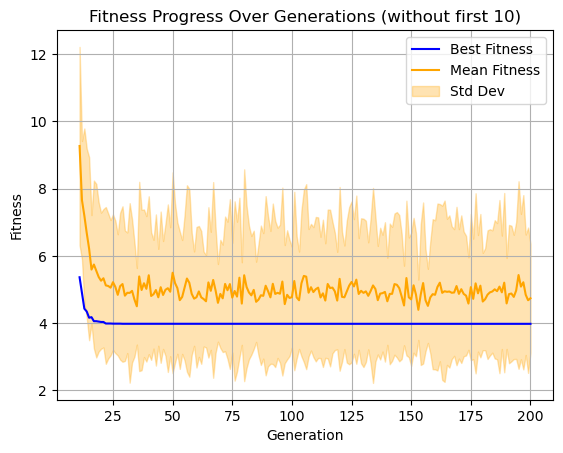


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 1.841881
Generation 20: Best Fitness = 0.314010
Generation 30: Best Fitness = 0.144001
Generation 40: Best Fitness = 0.086716
Generation 50: Best Fitness = 0.034107
Generation 60: Best Fitness = 0.025501
Generation 70: Best Fitness = 0.025501
Generation 80: Best Fitness = 0.014177
Generation 90: Best Fitness = 0.014177
Generation 100: Best Fitness = 0.014074
Generation 110: Best Fitness = 0.002657
Generation 120: Best Fitness = 0.001232
Generation 130: Best Fitness = 0.001232
Generation 140: Best Fitness = 0.001232
Generation 150: Best Fitness = 0.001029
Generation 160: Best Fitness = 0.001029
Generation 170: Best Fitness = 0.001029
Generation 180: Best Fitness = 0.001029
Generation 190: Best Fitness = 0.000690
Generation 200: Best Fitness = 0.000584
Best solution: [ 4.86848559e-06  4.15197429e-04 -2.55251891e-04 -1.56377308e-03
 -5.08160495e-04]
Best value: 0.000583502789993417

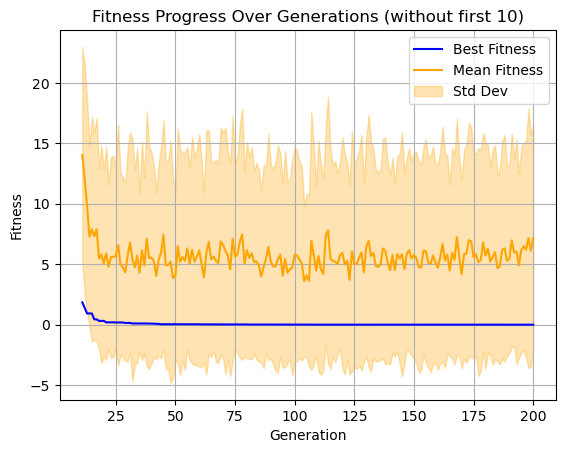


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 6.079903
Generation 20: Best Fitness = 1.221804
Generation 30: Best Fitness = 1.122668
Generation 40: Best Fitness = 1.037587
Generation 50: Best Fitness = 0.206384
Generation 60: Best Fitness = 0.196517
Generation 70: Best Fitness = 0.025410
Generation 80: Best Fitness = 0.025410
Generation 90: Best Fitness = 0.007764
Generation 100: Best Fitness = 0.010124
Generation 110: Best Fitness = 0.010028
Generation 120: Best Fitness = 0.005981
Generation 130: Best Fitness = 0.004372
Generation 140: Best Fitness = 0.001248
Generation 150: Best Fitness = 0.000324
Generation 160: Best Fitness = 0.000324
Generation 170: Best Fitness = 0.000316
Generation 180: Best Fitness = 0.000316
Generation 190: Best Fitness = 0.000316
Generation 200: Best Fitness = 0.000316
Best solution: [-1.20690385e-03  2.15063623e-04 -1.62790162e-04  2.46848763e-04
  6.06454743e-05]
Best value: 0.00031623205212127

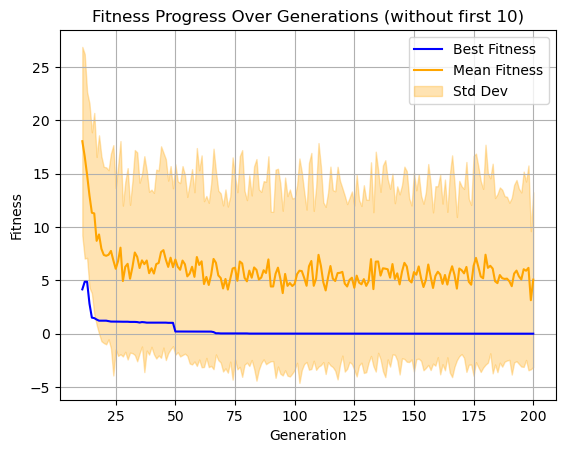


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 4.153210
Generation 20: Best Fitness = 0.806694
Generation 30: Best Fitness = 0.038738
Generation 40: Best Fitness = 0.031052
Generation 50: Best Fitness = 0.030297
Generation 60: Best Fitness = 0.014878
Generation 70: Best Fitness = 0.006856
Generation 80: Best Fitness = 0.003469
Generation 90: Best Fitness = 0.002590
Generation 100: Best Fitness = 0.002590
Generation 110: Best Fitness = 0.002194
Generation 120: Best Fitness = 0.002194
Generation 130: Best Fitness = 0.002194
Generation 140: Best Fitness = 0.001649
Generation 150: Best Fitness = 0.001649
Generation 160: Best Fitness = 0.001649
Generation 170: Best Fitness = 0.001649
Generation 180: Best Fitness = 0.001649
Generation 190: Best Fitness = 0.001649
Generation 200: Best Fitness = 0.001600
Best solution: [-4.33745172e-05 -1.70723972e-03 -1.40543156e-03  1.36299344e-03
  1.14750485e-03]
Best value: 0.001600279705286311

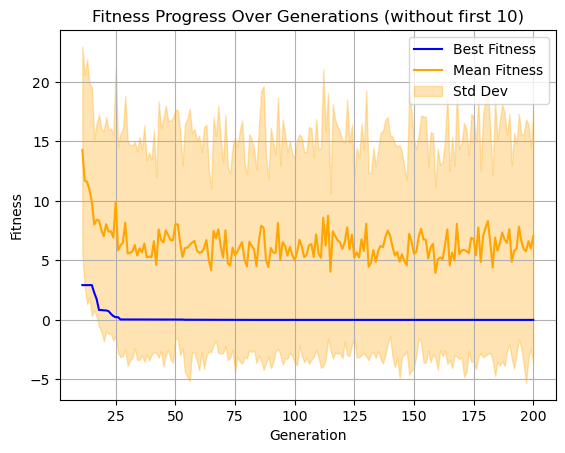


GA with crossover_rate=0.5, mutation_rate=0.1, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 8.608526
Generation 20: Best Fitness = 3.584344
Generation 30: Best Fitness = 0.487589
Generation 40: Best Fitness = 0.487589
Generation 50: Best Fitness = 0.414020
Generation 60: Best Fitness = 0.052888
Generation 70: Best Fitness = 0.046776
Generation 80: Best Fitness = 0.046776
Generation 90: Best Fitness = 0.031147
Generation 100: Best Fitness = 0.031147
Generation 110: Best Fitness = 0.013639
Generation 120: Best Fitness = 0.013639
Generation 130: Best Fitness = 0.013639
Generation 140: Best Fitness = 0.013639
Generation 150: Best Fitness = 0.011672
Generation 160: Best Fitness = 0.011672
Generation 170: Best Fitness = 0.011672
Generation 180: Best Fitness = 0.006532
Generation 190: Best Fitness = 0.006532
Generation 200: Best Fitness = 0.006349
Best solution: [ 0.00277917  0.00017717 -0.00460591 -0.00070108  0.00159415]
Best value: 0.006348681156168823


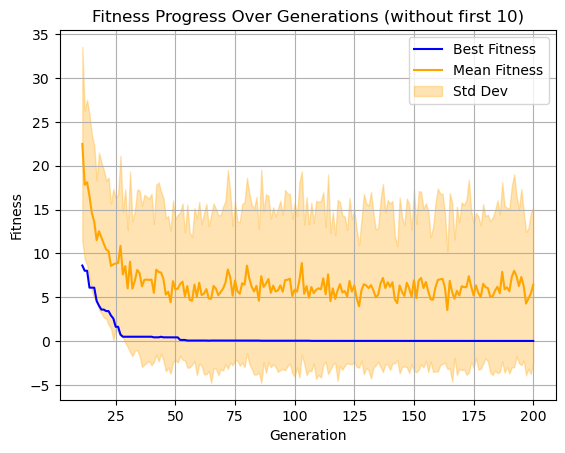


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 3.724203
Generation 20: Best Fitness = 1.257261
Generation 30: Best Fitness = 1.129106
Generation 40: Best Fitness = 1.129106
Generation 50: Best Fitness = 1.018074
Generation 60: Best Fitness = 1.018074
Generation 70: Best Fitness = 1.018074
Generation 80: Best Fitness = 1.018074
Generation 90: Best Fitness = 1.018074
Generation 100: Best Fitness = 0.999821
Generation 110: Best Fitness = 0.999821
Generation 120: Best Fitness = 0.999821
Generation 130: Best Fitness = 0.999821
Generation 140: Best Fitness = 0.999821
Generation 150: Best Fitness = 0.999821
Generation 160: Best Fitness = 0.999821
Generation 170: Best Fitness = 0.999821
Generation 180: Best Fitness = 0.999821
Generation 190: Best Fitness = 0.999821
Generation 200: Best Fitness = 0.999821
Best solution: [-0.00176607 -0.00193682 -0.99662796  0.00371298  0.00103124]
Best value: 0.9998206089836188


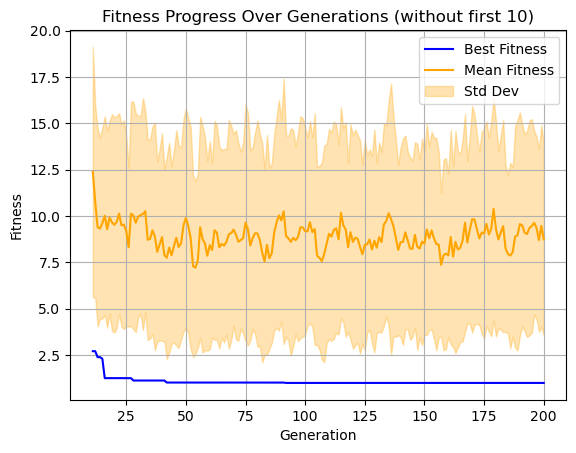


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 4.915659
Generation 20: Best Fitness = 3.039327
Generation 30: Best Fitness = 2.308180
Generation 40: Best Fitness = 2.518994
Generation 50: Best Fitness = 2.479739
Generation 60: Best Fitness = 2.984508
Generation 70: Best Fitness = 2.586048
Generation 80: Best Fitness = 2.754589
Generation 90: Best Fitness = 2.729845
Generation 100: Best Fitness = 2.507033
Generation 110: Best Fitness = 2.729309
Generation 120: Best Fitness = 2.849428
Generation 130: Best Fitness = 2.226829
Generation 140: Best Fitness = 2.670977
Generation 150: Best Fitness = 2.686591
Generation 160: Best Fitness = 3.354290
Generation 170: Best Fitness = 2.960251
Generation 180: Best Fitness = 2.443970
Generation 190: Best Fitness = 2.815017
Generation 200: Best Fitness = 3.087334
Best solution: [-0.93871618  0.02439848 -0.00726635  0.9926974   0.04210006]
Best value: 3.087334016850349


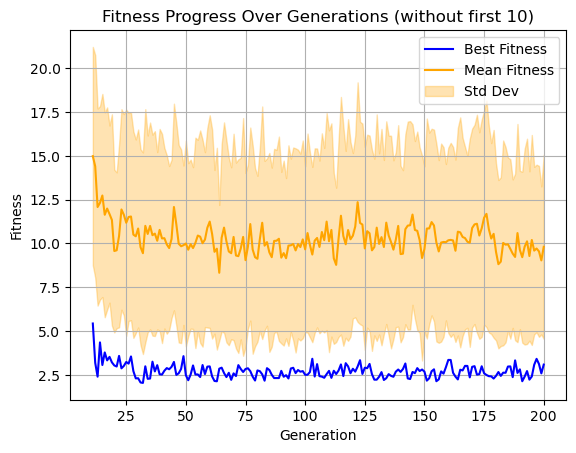


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 5.863545
Generation 20: Best Fitness = 5.725478
Generation 30: Best Fitness = 5.528947
Generation 40: Best Fitness = 4.778221
Generation 50: Best Fitness = 4.066821
Generation 60: Best Fitness = 4.064203
Generation 70: Best Fitness = 1.661571
Generation 80: Best Fitness = 1.661571
Generation 90: Best Fitness = 1.661571
Generation 100: Best Fitness = 1.256846
Generation 110: Best Fitness = 1.256846
Generation 120: Best Fitness = 1.256846
Generation 130: Best Fitness = 1.256846
Generation 140: Best Fitness = 1.256846
Generation 150: Best Fitness = 1.256846
Generation 160: Best Fitness = 1.256846
Generation 170: Best Fitness = 1.256846
Generation 180: Best Fitness = 1.256846
Generation 190: Best Fitness = 1.256846
Generation 200: Best Fitness = 1.256846
Best solution: [ 0.01710945 -0.00884759  0.98296364 -0.0154217   0.02385628]
Best value: 1.2568457310214427


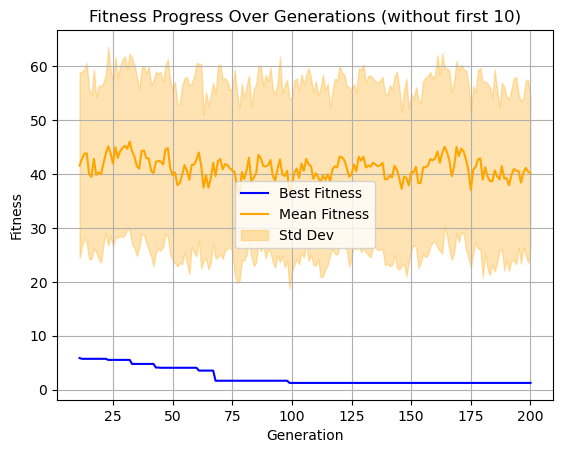


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 14.676497
Generation 20: Best Fitness = 11.153263
Generation 30: Best Fitness = 13.278970
Generation 40: Best Fitness = 10.783015
Generation 50: Best Fitness = 9.131990
Generation 60: Best Fitness = 10.858785
Generation 70: Best Fitness = 12.613410
Generation 80: Best Fitness = 11.595585
Generation 90: Best Fitness = 6.689469
Generation 100: Best Fitness = 6.528189
Generation 110: Best Fitness = 13.217378
Generation 120: Best Fitness = 12.048041
Generation 130: Best Fitness = 7.975973
Generation 140: Best Fitness = 11.896580
Generation 150: Best Fitness = 8.966008
Generation 160: Best Fitness = 12.151188
Generation 170: Best Fitness = 14.826381
Generation 180: Best Fitness = 13.529628
Generation 190: Best Fitness = 17.179069
Generation 200: Best Fitness = 15.143483
Best solution: [-2.08669157  0.16782707 -0.92976316  0.08447165  1.01087341]
Best value: 15.143483331433117


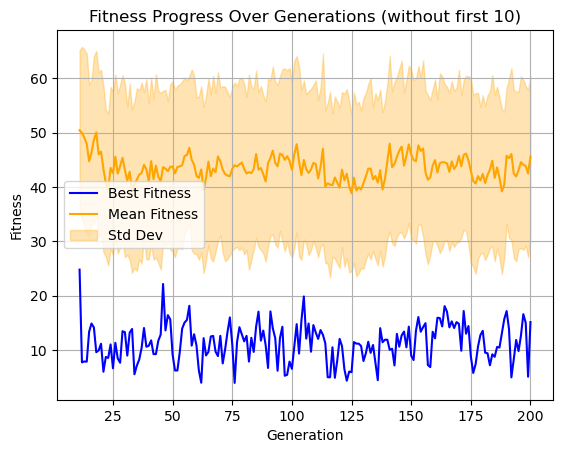


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 9.048402
Generation 20: Best Fitness = 5.575310
Generation 30: Best Fitness = 5.575310
Generation 40: Best Fitness = 5.575310
Generation 50: Best Fitness = 5.575310
Generation 60: Best Fitness = 5.317646
Generation 70: Best Fitness = 4.517695
Generation 80: Best Fitness = 2.216707
Generation 90: Best Fitness = 2.216707
Generation 100: Best Fitness = 2.216707
Generation 110: Best Fitness = 2.216707
Generation 120: Best Fitness = 2.167397
Generation 130: Best Fitness = 2.167397
Generation 140: Best Fitness = 1.645807
Generation 150: Best Fitness = 1.645807
Generation 160: Best Fitness = 1.645807
Generation 170: Best Fitness = 1.645807
Generation 180: Best Fitness = 1.645807
Generation 190: Best Fitness = 1.645807
Generation 200: Best Fitness = 1.645807
Best solution: [ 1.00349671  0.03461177 -0.00529418 -0.03070637  0.03240444]
Best value: 1.6458069763882008


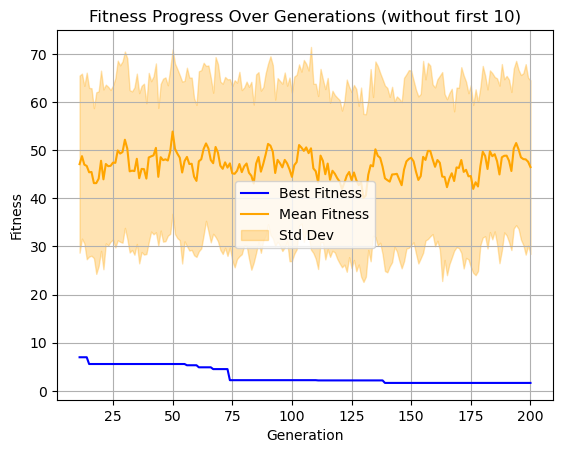


GA with crossover_rate=0.5, mutation_rate=0.5, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 8.863509
Generation 20: Best Fitness = 10.601161
Generation 30: Best Fitness = 10.726058
Generation 40: Best Fitness = 6.752929
Generation 50: Best Fitness = 16.976215
Generation 60: Best Fitness = 14.727774
Generation 70: Best Fitness = 15.494965
Generation 80: Best Fitness = 12.811156
Generation 90: Best Fitness = 19.271704
Generation 100: Best Fitness = 22.136739
Generation 110: Best Fitness = 11.451753
Generation 120: Best Fitness = 22.068267
Generation 130: Best Fitness = 11.625474
Generation 140: Best Fitness = 12.287865
Generation 150: Best Fitness = 14.123300
Generation 160: Best Fitness = 10.475330
Generation 170: Best Fitness = 14.274426
Generation 180: Best Fitness = 9.780045
Generation 190: Best Fitness = 18.311175
Generation 200: Best Fitness = 7.965414
Best solution: [-1.00390148 -0.95958309  0.88711732  0.94401302 -0.98596612]
Best value: 7.965414046256946


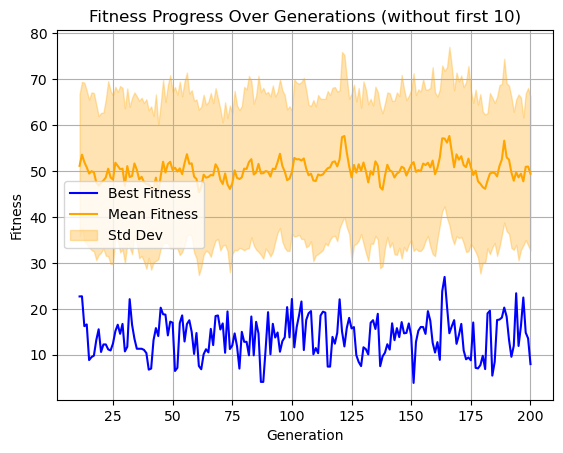


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 8.522596
Generation 20: Best Fitness = 4.981929
Generation 30: Best Fitness = 3.889467
Generation 40: Best Fitness = 3.889467
Generation 50: Best Fitness = 3.889467
Generation 60: Best Fitness = 3.801367
Generation 70: Best Fitness = 3.801367
Generation 80: Best Fitness = 3.801367
Generation 90: Best Fitness = 3.786100
Generation 100: Best Fitness = 3.312175
Generation 110: Best Fitness = 3.312175
Generation 120: Best Fitness = 3.312175
Generation 130: Best Fitness = 3.312175
Generation 140: Best Fitness = 3.312175
Generation 150: Best Fitness = 3.312175
Generation 160: Best Fitness = 3.153290
Generation 170: Best Fitness = 3.153290
Generation 180: Best Fitness = 3.153290
Generation 190: Best Fitness = 3.153290
Generation 200: Best Fitness = 3.153290
Best solution: [ 0.99809146 -0.0246384  -0.00860247  0.98993757 -1.00653797]
Best value: 3.153289643563511


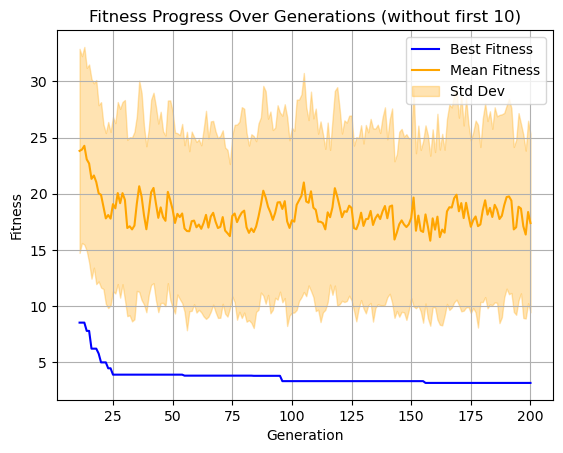


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 5.911144
Generation 20: Best Fitness = 4.434568
Generation 30: Best Fitness = 7.662640
Generation 40: Best Fitness = 5.216173
Generation 50: Best Fitness = 4.797928
Generation 60: Best Fitness = 5.393818
Generation 70: Best Fitness = 5.542048
Generation 80: Best Fitness = 5.724500
Generation 90: Best Fitness = 3.519096
Generation 100: Best Fitness = 4.725325
Generation 110: Best Fitness = 4.020928
Generation 120: Best Fitness = 5.202951
Generation 130: Best Fitness = 4.893028
Generation 140: Best Fitness = 3.450825
Generation 150: Best Fitness = 5.603814
Generation 160: Best Fitness = 4.741453
Generation 170: Best Fitness = 3.689826
Generation 180: Best Fitness = 4.060683
Generation 190: Best Fitness = 3.880062
Generation 200: Best Fitness = 5.036378
Best solution: [ 0.01052355  0.02266484 -1.06853149 -0.92900424 -1.00537718]
Best value: 5.036377534538531


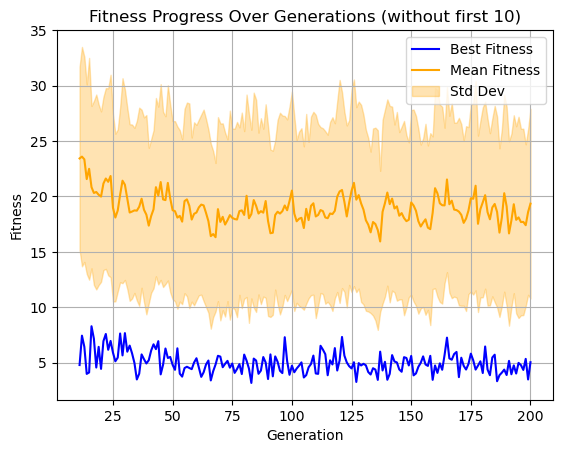


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 13.224560
Generation 20: Best Fitness = 7.487831
Generation 30: Best Fitness = 7.487831
Generation 40: Best Fitness = 6.077476
Generation 50: Best Fitness = 6.077476
Generation 60: Best Fitness = 6.077476
Generation 70: Best Fitness = 6.077476
Generation 80: Best Fitness = 6.077476
Generation 90: Best Fitness = 6.077476
Generation 100: Best Fitness = 6.077476
Generation 110: Best Fitness = 6.077476
Generation 120: Best Fitness = 6.077476
Generation 130: Best Fitness = 6.077476
Generation 140: Best Fitness = 6.077476
Generation 150: Best Fitness = 6.077476
Generation 160: Best Fitness = 6.077476
Generation 170: Best Fitness = 6.077476
Generation 180: Best Fitness = 6.077476
Generation 190: Best Fitness = 6.077476
Generation 200: Best Fitness = 6.077476
Best solution: [ 0.08300105  0.06212564  0.00713557 -1.01259347  0.89448471]
Best value: 6.077476081687763


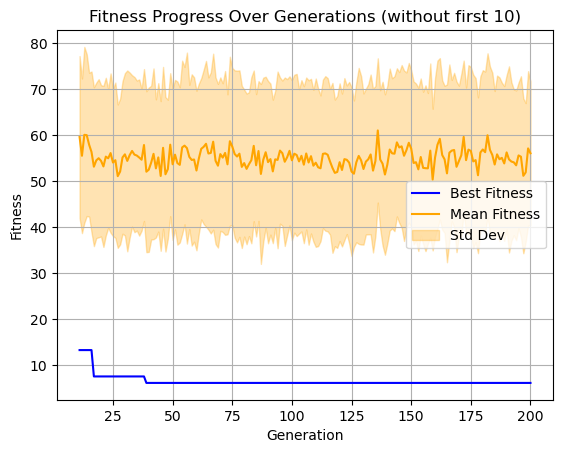


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 13.240552
Generation 20: Best Fitness = 16.873553
Generation 30: Best Fitness = 6.016057
Generation 40: Best Fitness = 25.358530
Generation 50: Best Fitness = 12.666364
Generation 60: Best Fitness = 13.248080
Generation 70: Best Fitness = 23.756800
Generation 80: Best Fitness = 16.907606
Generation 90: Best Fitness = 23.421404
Generation 100: Best Fitness = 18.527189
Generation 110: Best Fitness = 25.329495
Generation 120: Best Fitness = 21.797899
Generation 130: Best Fitness = 21.210649
Generation 140: Best Fitness = 15.369233
Generation 150: Best Fitness = 12.253004
Generation 160: Best Fitness = 12.922523
Generation 170: Best Fitness = 16.677957
Generation 180: Best Fitness = 18.315474
Generation 190: Best Fitness = 10.772013
Generation 200: Best Fitness = 13.147771
Best solution: [-1.11573825 -0.91462127 -0.04162758  2.10500029  0.0363269 ]
Best value: 13.147770695998638


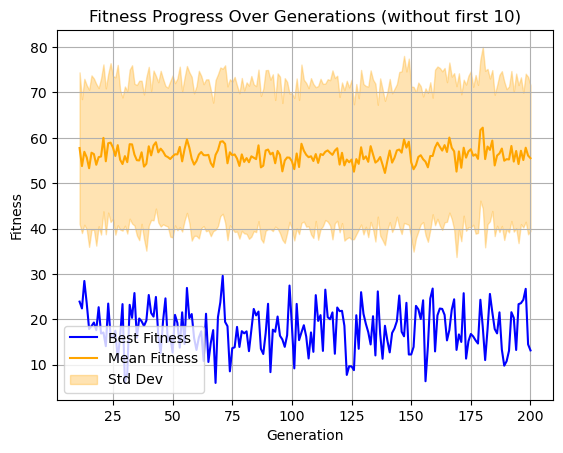


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 13.371194
Generation 20: Best Fitness = 13.371194
Generation 30: Best Fitness = 13.371194
Generation 40: Best Fitness = 10.639878
Generation 50: Best Fitness = 9.747357
Generation 60: Best Fitness = 8.768176
Generation 70: Best Fitness = 8.768176
Generation 80: Best Fitness = 8.768176
Generation 90: Best Fitness = 8.768176
Generation 100: Best Fitness = 8.768176
Generation 110: Best Fitness = 8.768176
Generation 120: Best Fitness = 8.768176
Generation 130: Best Fitness = 8.768176
Generation 140: Best Fitness = 8.768176
Generation 150: Best Fitness = 8.768176
Generation 160: Best Fitness = 8.768176
Generation 170: Best Fitness = 8.768176
Generation 180: Best Fitness = 8.768176
Generation 190: Best Fitness = 8.768176
Generation 200: Best Fitness = 8.768176
Best solution: [ 0.01233887  0.96755774 -0.15901783  1.05683576 -1.02955973]
Best value: 8.768175911129411


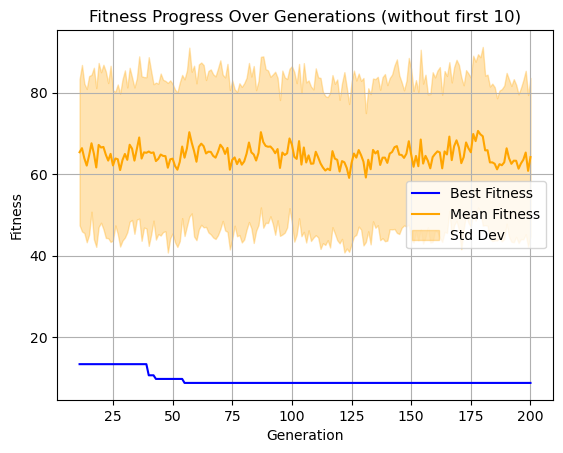


GA with crossover_rate=0.5, mutation_rate=0.9, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 29.497928
Generation 20: Best Fitness = 17.794702
Generation 30: Best Fitness = 25.351072
Generation 40: Best Fitness = 16.110856
Generation 50: Best Fitness = 23.264484
Generation 60: Best Fitness = 23.002232
Generation 70: Best Fitness = 21.337514
Generation 80: Best Fitness = 35.866906
Generation 90: Best Fitness = 29.829033
Generation 100: Best Fitness = 20.685303
Generation 110: Best Fitness = 28.031904
Generation 120: Best Fitness = 24.400545
Generation 130: Best Fitness = 23.589209
Generation 140: Best Fitness = 27.896096
Generation 150: Best Fitness = 25.383648
Generation 160: Best Fitness = 20.306583
Generation 170: Best Fitness = 17.924799
Generation 180: Best Fitness = 14.814438
Generation 190: Best Fitness = 17.028592
Generation 200: Best Fitness = 33.671284
Best solution: [ 0.66575488  1.04975319  0.91090775 -0.89765849 -0.27169708]
Best value: 33.67128416923292


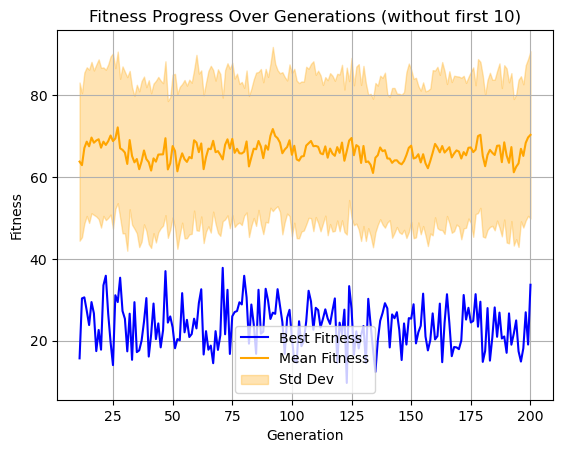


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 3.797886
Generation 20: Best Fitness = 3.035771
Generation 30: Best Fitness = 2.989984
Generation 40: Best Fitness = 2.987225
Generation 50: Best Fitness = 2.985376
Generation 60: Best Fitness = 2.985323
Generation 70: Best Fitness = 2.985323
Generation 80: Best Fitness = 2.985141
Generation 90: Best Fitness = 2.985045
Generation 100: Best Fitness = 2.985019
Generation 110: Best Fitness = 2.985019
Generation 120: Best Fitness = 2.985019
Generation 130: Best Fitness = 2.984909
Generation 140: Best Fitness = 2.984905
Generation 150: Best Fitness = 2.984905
Generation 160: Best Fitness = 2.984905
Generation 170: Best Fitness = 2.984905
Generation 180: Best Fitness = 2.984905
Generation 190: Best Fitness = 2.984905
Generation 200: Best Fitness = 2.984905
Best solution: [ 1.41249130e-05 -1.64618970e-04  9.94758936e-01  9.94999522e-01
  9.95225349e-01]
Best value: 2.9849049324383543


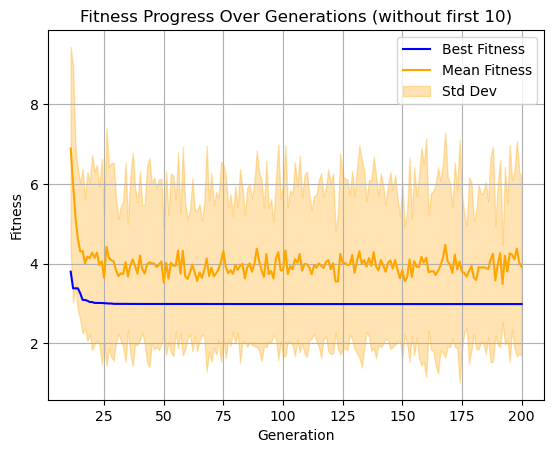


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 3.159423
Generation 20: Best Fitness = 2.133646
Generation 30: Best Fitness = 1.998663
Generation 40: Best Fitness = 1.992758
Generation 50: Best Fitness = 1.991193
Generation 60: Best Fitness = 1.991036
Generation 70: Best Fitness = 1.991174
Generation 80: Best Fitness = 1.991174
Generation 90: Best Fitness = 1.991174
Generation 100: Best Fitness = 1.991034
Generation 110: Best Fitness = 1.990676
Generation 120: Best Fitness = 1.990644
Generation 130: Best Fitness = 1.990565
Generation 140: Best Fitness = 1.990324
Generation 150: Best Fitness = 1.990324
Generation 160: Best Fitness = 1.990028
Generation 170: Best Fitness = 1.990028
Generation 180: Best Fitness = 1.990028
Generation 190: Best Fitness = 1.990028
Generation 200: Best Fitness = 1.990028
Best solution: [ 6.93488257e-05  3.32000793e-05 -9.95205155e-01  9.94819632e-01
 -6.84423159e-04]
Best value: 1.9900281027240965


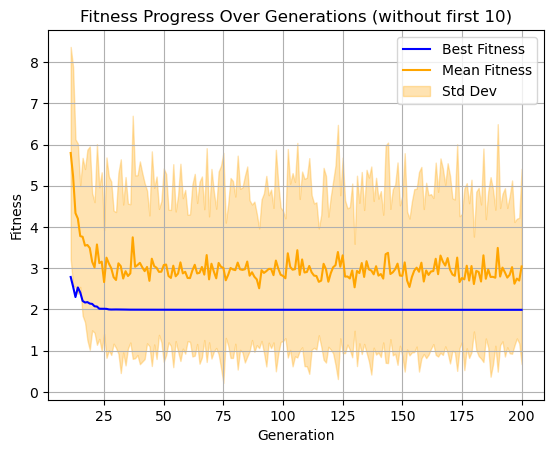


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 2.946501
Generation 20: Best Fitness = 0.651745
Generation 30: Best Fitness = 0.214718
Generation 40: Best Fitness = 0.161968
Generation 50: Best Fitness = 0.050029
Generation 60: Best Fitness = 0.050029
Generation 70: Best Fitness = 0.039434
Generation 80: Best Fitness = 0.032366
Generation 90: Best Fitness = 0.016834
Generation 100: Best Fitness = 0.013731
Generation 110: Best Fitness = 0.013461
Generation 120: Best Fitness = 0.005903
Generation 130: Best Fitness = 0.005903
Generation 140: Best Fitness = 0.005903
Generation 150: Best Fitness = 0.004209
Generation 160: Best Fitness = 0.004209
Generation 170: Best Fitness = 0.003677
Generation 180: Best Fitness = 0.003677
Generation 190: Best Fitness = 0.003542
Generation 200: Best Fitness = 0.000587
Best solution: [-0.00012913 -0.00096029  0.00065851  0.00012002 -0.00125354]
Best value: 0.0005868876173167337


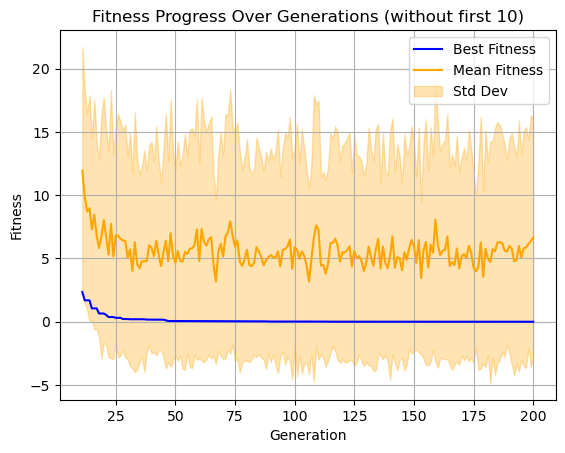


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 2.412513
Generation 20: Best Fitness = 1.146212
Generation 30: Best Fitness = 0.024197
Generation 40: Best Fitness = 0.023039
Generation 50: Best Fitness = 0.008688
Generation 60: Best Fitness = 0.004710
Generation 70: Best Fitness = 0.003622
Generation 80: Best Fitness = 0.002193
Generation 90: Best Fitness = 0.001234
Generation 100: Best Fitness = 0.000951
Generation 110: Best Fitness = 0.000951
Generation 120: Best Fitness = 0.000951
Generation 130: Best Fitness = 0.000951
Generation 140: Best Fitness = 0.000933
Generation 150: Best Fitness = 0.000933
Generation 160: Best Fitness = 0.000933
Generation 170: Best Fitness = 0.000933
Generation 180: Best Fitness = 0.000933
Generation 190: Best Fitness = 0.000933
Generation 200: Best Fitness = 0.000933
Best solution: [-0.000391   -0.00149606  0.00045404  0.00012563  0.00144583]
Best value: 0.00093311760593906


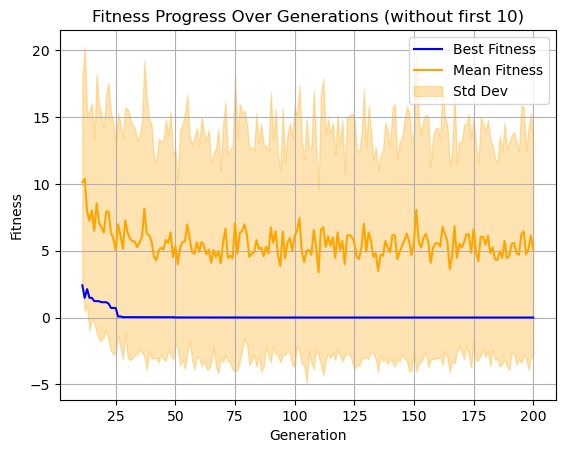


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 3.034214
Generation 20: Best Fitness = 0.713171
Generation 30: Best Fitness = 0.316395
Generation 40: Best Fitness = 0.097165
Generation 50: Best Fitness = 0.039808
Generation 60: Best Fitness = 0.039808
Generation 70: Best Fitness = 0.039808
Generation 80: Best Fitness = 0.039808
Generation 90: Best Fitness = 0.024669
Generation 100: Best Fitness = 0.003890
Generation 110: Best Fitness = 0.003890
Generation 120: Best Fitness = 0.003801
Generation 130: Best Fitness = 0.003585
Generation 140: Best Fitness = 0.001274
Generation 150: Best Fitness = 0.001274
Generation 160: Best Fitness = 0.001274
Generation 170: Best Fitness = 0.001132
Generation 180: Best Fitness = 0.001132
Generation 190: Best Fitness = 0.001132
Generation 200: Best Fitness = 0.001132
Best solution: [-0.00037378  0.00175537 -0.00085625 -0.00042835 -0.00125255]
Best value: 0.0011321332802864958


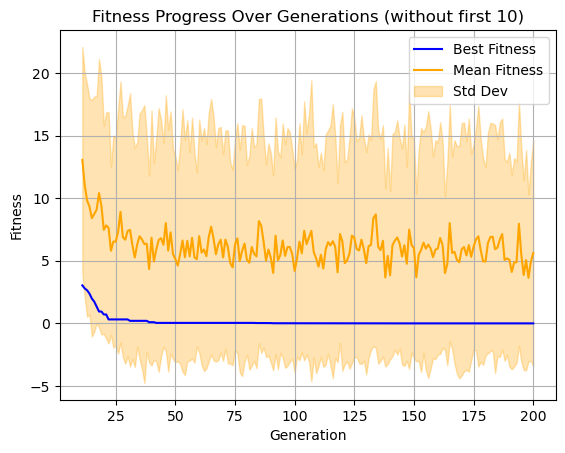


GA with crossover_rate=0.9, mutation_rate=0.1, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 6.651497
Generation 20: Best Fitness = 2.283448
Generation 30: Best Fitness = 0.960967
Generation 40: Best Fitness = 0.493956
Generation 50: Best Fitness = 0.252290
Generation 60: Best Fitness = 0.045764
Generation 70: Best Fitness = 0.021429
Generation 80: Best Fitness = 0.021429
Generation 90: Best Fitness = 0.009284
Generation 100: Best Fitness = 0.009284
Generation 110: Best Fitness = 0.008940
Generation 120: Best Fitness = 0.008940
Generation 130: Best Fitness = 0.003963
Generation 140: Best Fitness = 0.003963
Generation 150: Best Fitness = 0.001821
Generation 160: Best Fitness = 0.001595
Generation 170: Best Fitness = 0.001595
Generation 180: Best Fitness = 0.001562
Generation 190: Best Fitness = 0.001562
Generation 200: Best Fitness = 0.001562
Best solution: [-0.00094185  0.00028402  0.00087094  0.0014934   0.00197942]
Best value: 0.0015622542466289246


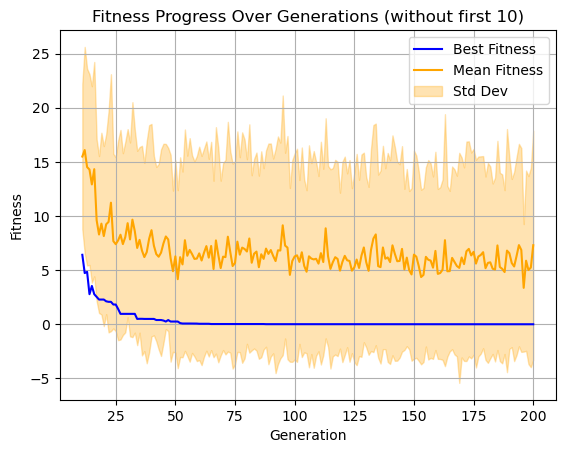


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 6.436632
Generation 20: Best Fitness = 5.261312
Generation 30: Best Fitness = 5.261312
Generation 40: Best Fitness = 5.236847
Generation 50: Best Fitness = 5.077606
Generation 60: Best Fitness = 5.077606
Generation 70: Best Fitness = 5.077606
Generation 80: Best Fitness = 5.077606
Generation 90: Best Fitness = 5.077606
Generation 100: Best Fitness = 5.057834
Generation 110: Best Fitness = 5.038188
Generation 120: Best Fitness = 4.986411
Generation 130: Best Fitness = 4.986411
Generation 140: Best Fitness = 4.986411
Generation 150: Best Fitness = 4.986411
Generation 160: Best Fitness = 4.986411
Generation 170: Best Fitness = 4.986411
Generation 180: Best Fitness = 4.986411
Generation 190: Best Fitness = 4.986411
Generation 200: Best Fitness = 4.985275
Best solution: [ 1.98565976  0.0043094   0.0023605  -0.99548326 -0.00322395]
Best value: 4.985274547766011


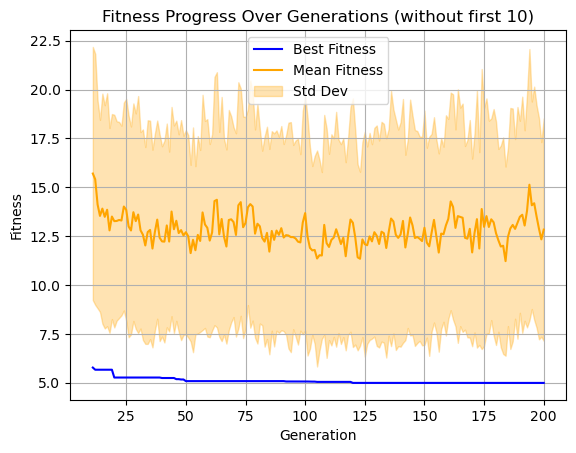


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 3.701979
Generation 20: Best Fitness = 3.735845
Generation 30: Best Fitness = 3.215035
Generation 40: Best Fitness = 2.627354
Generation 50: Best Fitness = 2.157749
Generation 60: Best Fitness = 3.258990
Generation 70: Best Fitness = 2.442569
Generation 80: Best Fitness = 2.774520
Generation 90: Best Fitness = 3.190464
Generation 100: Best Fitness = 2.931018
Generation 110: Best Fitness = 2.104046
Generation 120: Best Fitness = 2.931192
Generation 130: Best Fitness = 2.717476
Generation 140: Best Fitness = 2.440242
Generation 150: Best Fitness = 2.591061
Generation 160: Best Fitness = 2.718119
Generation 170: Best Fitness = 3.005122
Generation 180: Best Fitness = 3.006680
Generation 190: Best Fitness = 3.418339
Generation 200: Best Fitness = 2.753935
Best solution: [ 0.98718813  0.03740325 -0.02243654  0.01570207  1.03563465]
Best value: 2.7539347543493733


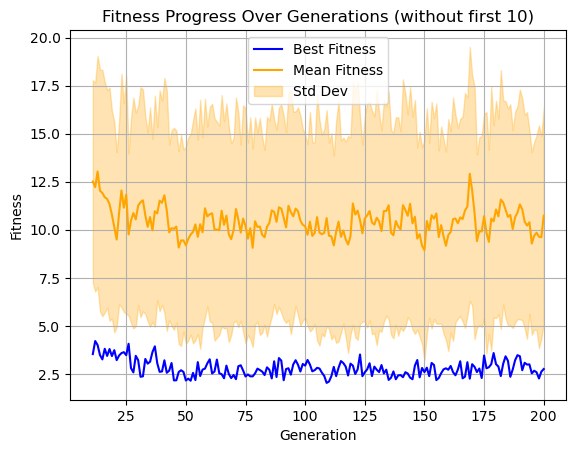


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 7.356331
Generation 20: Best Fitness = 2.369152
Generation 30: Best Fitness = 1.831986
Generation 40: Best Fitness = 1.831986
Generation 50: Best Fitness = 1.831986
Generation 60: Best Fitness = 1.831986
Generation 70: Best Fitness = 1.831986
Generation 80: Best Fitness = 1.791237
Generation 90: Best Fitness = 1.791237
Generation 100: Best Fitness = 1.791237
Generation 110: Best Fitness = 1.791237
Generation 120: Best Fitness = 1.791237
Generation 130: Best Fitness = 1.791237
Generation 140: Best Fitness = 1.791237
Generation 150: Best Fitness = 1.791237
Generation 160: Best Fitness = 1.791237
Generation 170: Best Fitness = 1.791237
Generation 180: Best Fitness = 1.791237
Generation 190: Best Fitness = 1.791237
Generation 200: Best Fitness = 1.791237
Best solution: [-0.01632148  0.00647618  1.02627934  0.04750194 -0.02207137]
Best value: 1.7912368486370625


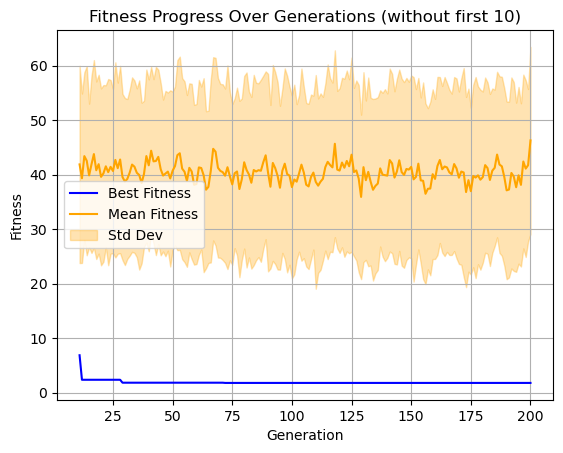


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 10.731230
Generation 20: Best Fitness = 9.387995
Generation 30: Best Fitness = 8.896848
Generation 40: Best Fitness = 7.501494
Generation 50: Best Fitness = 12.177619
Generation 60: Best Fitness = 11.946461
Generation 70: Best Fitness = 8.920112
Generation 80: Best Fitness = 6.305843
Generation 90: Best Fitness = 13.841830
Generation 100: Best Fitness = 12.388216
Generation 110: Best Fitness = 11.871186
Generation 120: Best Fitness = 8.892091
Generation 130: Best Fitness = 13.790815
Generation 140: Best Fitness = 10.516896
Generation 150: Best Fitness = 13.842076
Generation 160: Best Fitness = 7.439547
Generation 170: Best Fitness = 7.976482
Generation 180: Best Fitness = 11.148888
Generation 190: Best Fitness = 11.965681
Generation 200: Best Fitness = 16.291262
Best solution: [-0.12104717  1.02402542  1.13700435  1.08180513  1.1438359 ]
Best value: 16.29126218965807


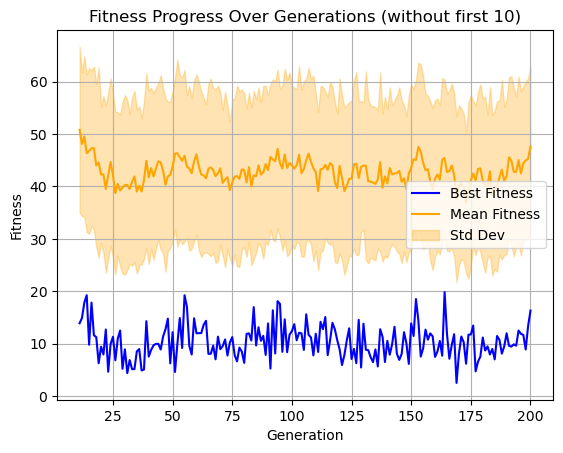


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 3.991131
Generation 20: Best Fitness = 2.627259
Generation 30: Best Fitness = 2.511448
Generation 40: Best Fitness = 2.511448
Generation 50: Best Fitness = 2.511448
Generation 60: Best Fitness = 2.511448
Generation 70: Best Fitness = 2.511448
Generation 80: Best Fitness = 2.511448
Generation 90: Best Fitness = 2.511448
Generation 100: Best Fitness = 2.511448
Generation 110: Best Fitness = 2.511448
Generation 120: Best Fitness = 2.511448
Generation 130: Best Fitness = 2.511448
Generation 140: Best Fitness = 2.511448
Generation 150: Best Fitness = 2.511448
Generation 160: Best Fitness = 2.511448
Generation 170: Best Fitness = 2.511448
Generation 180: Best Fitness = 2.511448
Generation 190: Best Fitness = 2.155001
Generation 200: Best Fitness = 2.155001
Best solution: [ 0.06619615 -0.03183644 -0.04674787  0.04737101 -0.03375773]
Best value: 2.155001387235835


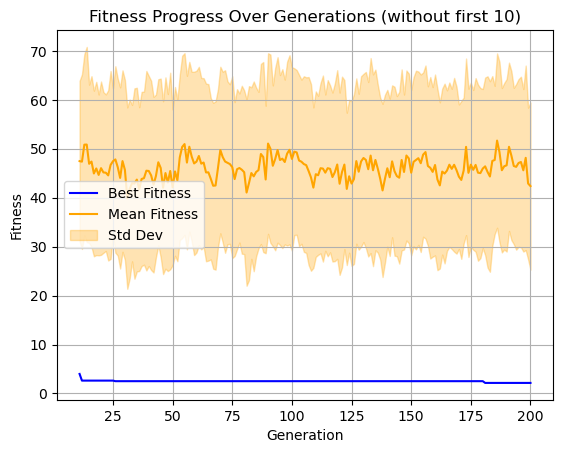


GA with crossover_rate=0.9, mutation_rate=0.5, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 16.459619
Generation 20: Best Fitness = 16.842483
Generation 30: Best Fitness = 8.389131
Generation 40: Best Fitness = 15.767809
Generation 50: Best Fitness = 17.734499
Generation 60: Best Fitness = 13.725063
Generation 70: Best Fitness = 12.999691
Generation 80: Best Fitness = 12.429556
Generation 90: Best Fitness = 13.738909
Generation 100: Best Fitness = 10.994658
Generation 110: Best Fitness = 10.209197
Generation 120: Best Fitness = 13.605016
Generation 130: Best Fitness = 12.632494
Generation 140: Best Fitness = 18.018645
Generation 150: Best Fitness = 9.535464
Generation 160: Best Fitness = 16.434001
Generation 170: Best Fitness = 4.998537
Generation 180: Best Fitness = 9.007400
Generation 190: Best Fitness = 17.190955
Generation 200: Best Fitness = 20.087567
Best solution: [-0.10075931  0.20070354 -0.85217875  0.06616561  1.15202922]
Best value: 20.087567187210897


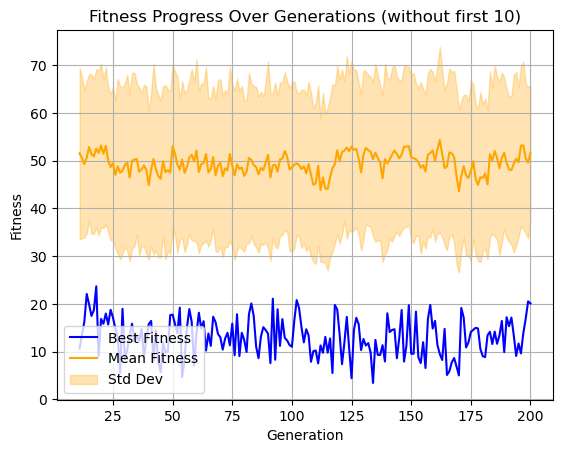


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=0.1, elitism=True
Generation 10: Best Fitness = 6.927075
Generation 20: Best Fitness = 3.716680
Generation 30: Best Fitness = 3.373257
Generation 40: Best Fitness = 2.201775
Generation 50: Best Fitness = 2.201775
Generation 60: Best Fitness = 2.201775
Generation 70: Best Fitness = 2.201775
Generation 80: Best Fitness = 2.201775
Generation 90: Best Fitness = 2.201775
Generation 100: Best Fitness = 2.201775
Generation 110: Best Fitness = 2.201775
Generation 120: Best Fitness = 2.201775
Generation 130: Best Fitness = 2.201775
Generation 140: Best Fitness = 2.201775
Generation 150: Best Fitness = 2.201775
Generation 160: Best Fitness = 2.201775
Generation 170: Best Fitness = 2.201775
Generation 180: Best Fitness = 2.201775
Generation 190: Best Fitness = 2.201775
Generation 200: Best Fitness = 2.201775
Best solution: [ 0.01573619  0.01893233 -0.99442106 -0.02134128 -0.99767338]
Best value: 2.20177466579797


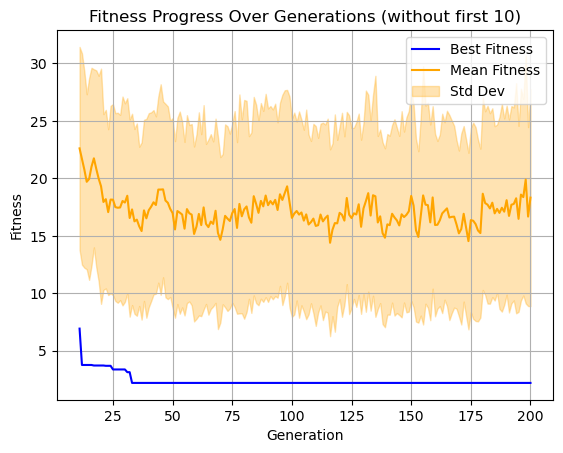


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=0.1, elitism=False
Generation 10: Best Fitness = 6.638917
Generation 20: Best Fitness = 3.189544
Generation 30: Best Fitness = 4.139861
Generation 40: Best Fitness = 2.562466
Generation 50: Best Fitness = 2.717263
Generation 60: Best Fitness = 4.159457
Generation 70: Best Fitness = 2.621212
Generation 80: Best Fitness = 3.019482
Generation 90: Best Fitness = 3.461614
Generation 100: Best Fitness = 3.960875
Generation 110: Best Fitness = 3.464841
Generation 120: Best Fitness = 3.060862
Generation 130: Best Fitness = 4.997118
Generation 140: Best Fitness = 4.997032
Generation 150: Best Fitness = 3.709254
Generation 160: Best Fitness = 4.130666
Generation 170: Best Fitness = 2.940720
Generation 180: Best Fitness = 5.709898
Generation 190: Best Fitness = 4.546801
Generation 200: Best Fitness = 2.864325
Best solution: [-0.01520517 -0.01714835 -1.04753265  1.00053664  0.03329101]
Best value: 2.8643252534213914


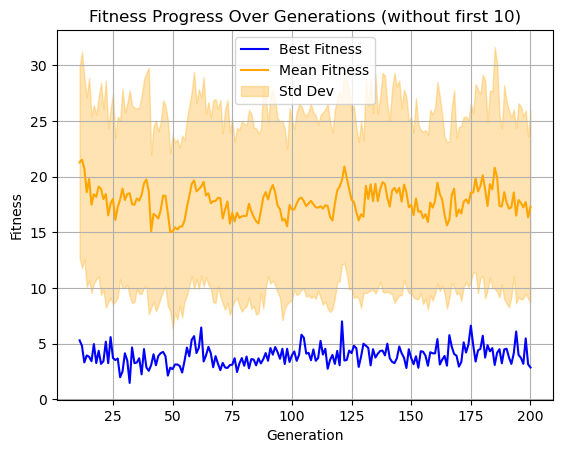


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=0.5, elitism=True
Generation 10: Best Fitness = 14.868226
Generation 20: Best Fitness = 11.912633
Generation 30: Best Fitness = 10.287798
Generation 40: Best Fitness = 9.169864
Generation 50: Best Fitness = 8.436939
Generation 60: Best Fitness = 6.776891
Generation 70: Best Fitness = 6.776891
Generation 80: Best Fitness = 6.776891
Generation 90: Best Fitness = 6.776891
Generation 100: Best Fitness = 6.776891
Generation 110: Best Fitness = 6.776891
Generation 120: Best Fitness = 6.776891
Generation 130: Best Fitness = 5.428632
Generation 140: Best Fitness = 5.428632
Generation 150: Best Fitness = 5.428632
Generation 160: Best Fitness = 5.428632
Generation 170: Best Fitness = 5.428632
Generation 180: Best Fitness = 5.428632
Generation 190: Best Fitness = 5.428632
Generation 200: Best Fitness = 5.428632
Best solution: [-1.0789275  -0.97897843  1.01647025 -0.06518396  0.02205729]
Best value: 5.428632316743524


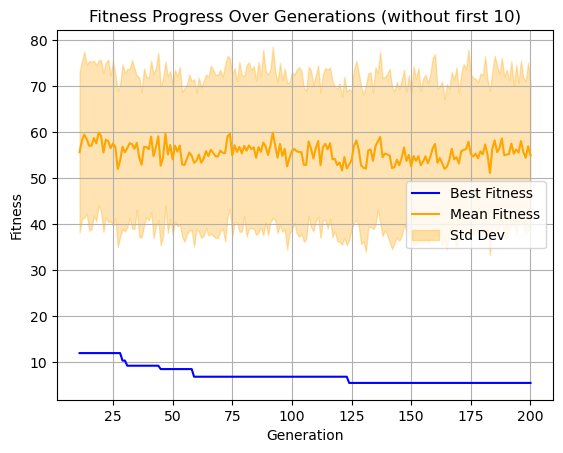


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=0.5, elitism=False
Generation 10: Best Fitness = 18.207881
Generation 20: Best Fitness = 19.586108
Generation 30: Best Fitness = 19.194162
Generation 40: Best Fitness = 18.637230
Generation 50: Best Fitness = 24.077322
Generation 60: Best Fitness = 11.360404
Generation 70: Best Fitness = 18.087534
Generation 80: Best Fitness = 17.010642
Generation 90: Best Fitness = 14.267240
Generation 100: Best Fitness = 13.220484
Generation 110: Best Fitness = 12.654124
Generation 120: Best Fitness = 24.933547
Generation 130: Best Fitness = 24.384395
Generation 140: Best Fitness = 28.807781
Generation 150: Best Fitness = 14.296134
Generation 160: Best Fitness = 17.558197
Generation 170: Best Fitness = 22.328176
Generation 180: Best Fitness = 17.662934
Generation 190: Best Fitness = 21.546178
Generation 200: Best Fitness = 16.288318
Best solution: [-1.90832147  0.94962269 -0.88358177  0.92465043 -2.03260632]
Best value: 16.28831771315336


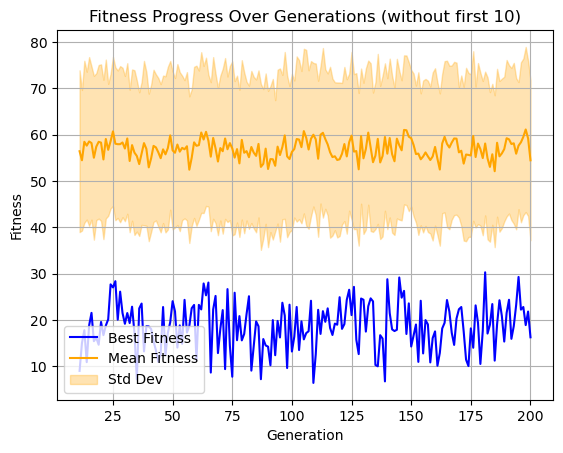


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=1.0, elitism=True
Generation 10: Best Fitness = 12.637498
Generation 20: Best Fitness = 12.637498
Generation 30: Best Fitness = 12.637498
Generation 40: Best Fitness = 12.637498
Generation 50: Best Fitness = 8.416800
Generation 60: Best Fitness = 8.416800
Generation 70: Best Fitness = 8.416800
Generation 80: Best Fitness = 8.416800
Generation 90: Best Fitness = 8.416800
Generation 100: Best Fitness = 8.416800
Generation 110: Best Fitness = 8.416800
Generation 120: Best Fitness = 8.416800
Generation 130: Best Fitness = 8.416800
Generation 140: Best Fitness = 8.416800
Generation 150: Best Fitness = 8.416800
Generation 160: Best Fitness = 8.416800
Generation 170: Best Fitness = 8.416800
Generation 180: Best Fitness = 7.945728
Generation 190: Best Fitness = 7.945728
Generation 200: Best Fitness = 7.388179
Best solution: [-0.06341821 -0.12736273 -1.06728889  0.00231212 -0.94273325]
Best value: 7.388178564752145


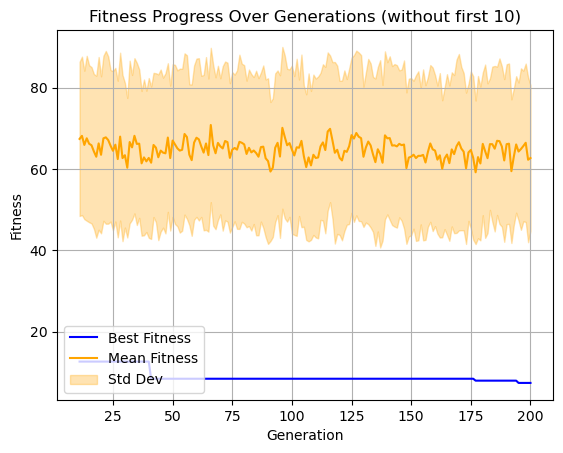


GA with crossover_rate=0.9, mutation_rate=0.9, mutation_std=1.0, elitism=False
Generation 10: Best Fitness = 24.153322
Generation 20: Best Fitness = 24.007480
Generation 30: Best Fitness = 15.204730
Generation 40: Best Fitness = 23.082708
Generation 50: Best Fitness = 18.145280
Generation 60: Best Fitness = 23.928837
Generation 70: Best Fitness = 25.029389
Generation 80: Best Fitness = 20.581193
Generation 90: Best Fitness = 15.216481
Generation 100: Best Fitness = 33.551170
Generation 110: Best Fitness = 9.117409
Generation 120: Best Fitness = 22.814620
Generation 130: Best Fitness = 20.774298
Generation 140: Best Fitness = 26.021697
Generation 150: Best Fitness = 16.871708
Generation 160: Best Fitness = 16.748683
Generation 170: Best Fitness = 20.249426
Generation 180: Best Fitness = 27.867390
Generation 190: Best Fitness = 15.172345
Generation 200: Best Fitness = 30.426025
Best solution: [-1.81781546 -0.89187038  0.09561813 -1.01656915 -0.33846347]
Best value: 30.426024891504227


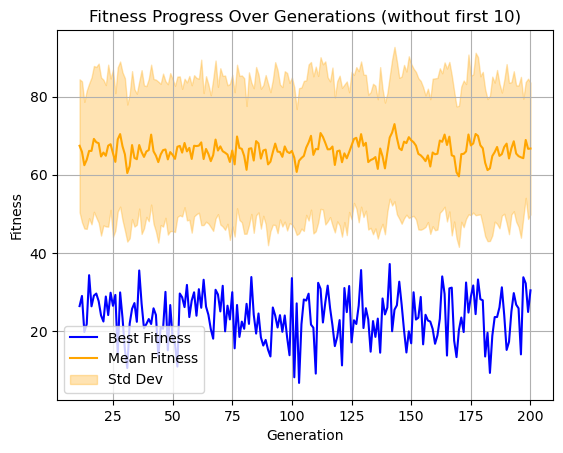

In [8]:
results_rastrigin = []

for crossover_rate in crossover_rates:
    for mutation_rate in mutation_rates:
        for mutation_std in mutation_stds:
            for elitism in elitism_options:
                print(f"\nGA with crossover_rate={crossover_rate}, mutation_rate={mutation_rate}, mutation_std={mutation_std}, elitism={elitism}")
                
                ga_rastrigin = GeneticAlgorithm(
                    objective_function=rastrigin,
                    dimension=5,
                    bounds=(-5.12, 5.12),
                    population_size=100,
                    mutation_std=mutation_std,
                    crossover_rate=crossover_rate,
                    mutation_rate=mutation_rate,
                    elitism=elitism
                )
                best_solution, best_value = ga_rastrigin.evolve(generations=200)
                
                results_rastrigin.append({
                    'crossover_rate': crossover_rate,
                    'mutation_rate': mutation_rate,
                    'mutation_std': mutation_std,
                    'elitism': elitism,
                    'best_value': best_value
                })
                
                print("Best solution:", best_solution)
                print("Best value:", best_value)
                ga_rastrigin.plot_fitness_progress()
                
results_rastrigin_df = pd.DataFrame(results_rastrigin)

In [9]:
results_rastrigin_df

crossover_rate  mutation_rate  mutation_std  elitism  best_value
0              0.1            0.1           0.1     True    5.969884
1              0.1            0.1           0.1    False    5.969811
2              0.1            0.1           0.5     True    0.000220
3              0.1            0.1           0.5    False    0.002139
4              0.1            0.1           1.0     True    0.000858
5              0.1            0.1           1.0    False    0.013821
6              0.1            0.5           0.1     True    6.976933
7              0.1            0.5           0.1    False    2.761284
8              0.1            0.5           0.5     True    0.933825
9              0.1            0.5           0.5    False    6.679431
10             0.1            0.5           1.0     True    4.850527
11             0.1            0.5           1.0    False   22.678524
12             0.1            0.9           0.1     True   13.169957
13             0.1            0.9           0.1    False    6.639949
14             0.1            0.9           0.5     True    4.840986
15             0.1            0.9           0.5    False   11.390553
16             0.1            0.9           1.0     True    5.375057
17             0.1            0.9           1.0    False   20.387391
18             0.5            0.1           0.1     True    4.974797
19             0.5            0.1           0.1    False    3.979876
20             0.5            0.1           0.5     True    0.000584
21             0.5            0.1           0.5    False    0.000316
22             0.5            0.1           1.0     True    0.001600
23             0.5            0.1           1.0    False    0.006349
24             0.5            0.5           0.1     True    0.999821
25             0.5            0.5           0.1    False    3.087334
26             0.5            0.5           0.5     True    1.256846
27             0.5            0.5           0.5    False   15.143483
28             0.5            0.5           1.0     True    1.645807
29             0.5            0.5           1.0    False    7.965414
30             0.5            0.9           0.1     True    3.153290
31             0.5            0.9           0.1    False    5.036378
32             0.5            0.9           0.5     True    6.077476
33             0.5            0.9           0.5    False   13.147771
34             0.5            0.9           1.0     True    8.768176
35             0.5            0.9           1.0    False   33.671284
36             0.9            0.1           0.1     True    2.984905
37             0.9            0.1           0.1    False    1.990028
38             0.9            0.1           0.5     True    0.000587
39             0.9            0.1           0.5    False    0.000933
40             0.9            0.1           1.0     True    0.001132
41             0.9            0.1           1.0    False    0.001562
42             0.9            0.5           0.1     True    4.985275
43             0.9            0.5           0.1    False    2.753935
44             0.9            0.5           0.5     True    1.791237
45             0.9            0.5           0.5    False   16.291262
46             0.9            0.5           1.0     True    2.155001
47             0.9            0.5           1.0    False   20.087567
48             0.9            0.9           0.1     True    2.201775
49             0.9            0.9           0.1    False    2.864325
50             0.9            0.9           0.5     True    5.428632
51             0.9            0.9           0.5    False   16.288318
52             0.9            0.9           1.0     True    7.388179
53             0.9            0.9           1.0    False   30.426025

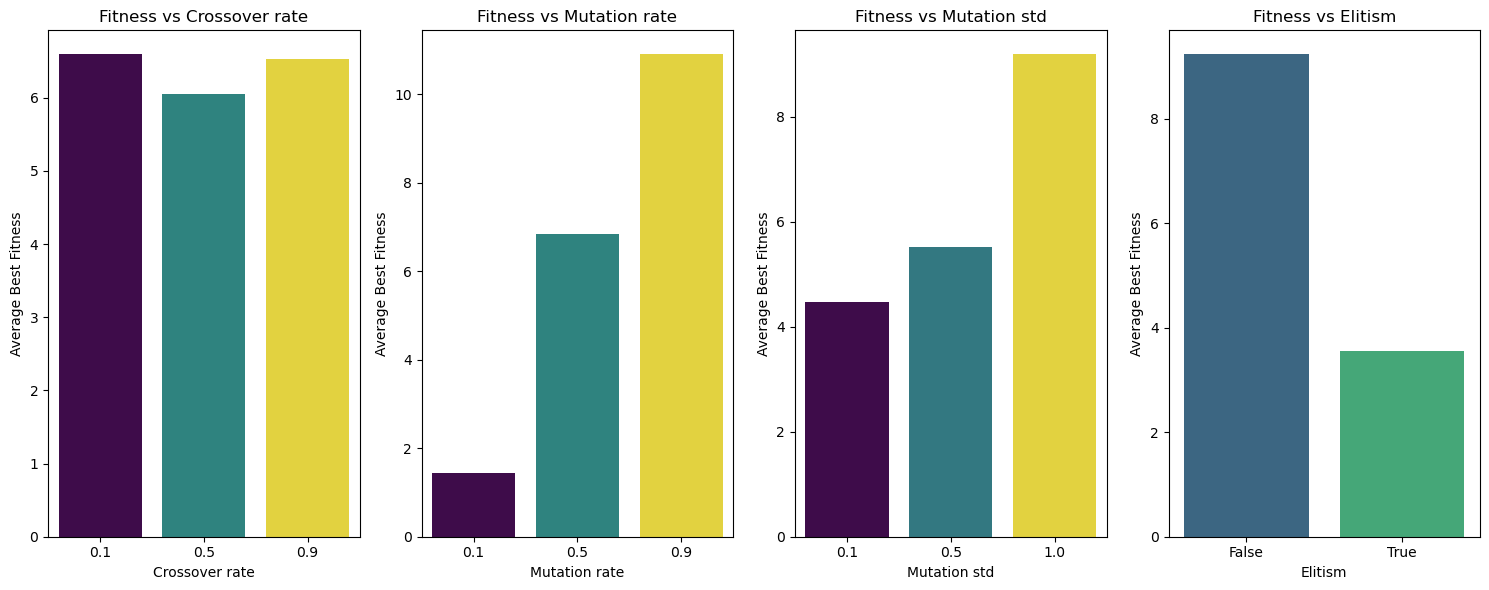

In [10]:
params = ['crossover_rate', 'mutation_rate', 'mutation_std', 'elitism']

plt.figure(figsize=(15, 6))

for i, param in enumerate(params, 1):
    plt.subplot(1, 4, i)
    
    grouped = results_rastrigin_df.groupby(param)['best_value'].mean().reset_index()
    
    if param == 'elitism':
        grouped[param] = grouped[param].astype(str)
    
    sns.barplot(x=param, y='best_value', data=grouped, palette='viridis', hue=param, legend=None)
    plt.xlabel(param.replace('_', ' ').capitalize())
    plt.ylabel('Average Best Fitness')
    plt.title(f'Fitness vs {param.replace("_", " ").capitalize()}')

plt.tight_layout()
plt.show()

As can be seen, the results are very satisfying; in both cases, it was possible to find parameters for which the found minima are very close to the true ones.